In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nashpy as nash
import itertools
import cvxpy as cp
import cvxopt
from tqdm import tqdm
import seaborn as sb
from scipy.stats import skewnorm
from scipy.optimize import minimize
import pickle
from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm

## 1. Histogram for All Years and FICS

In [3]:
def create_bins(lower_bound, upper_bound, n):
    width = (upper_bound - lower_bound) / n
    
    ub = lower_bound + width; lb = lower_bound; bins = [(lb, ub)]
    for _ in range(n-1):
        lb += width; ub += width; bins.append((lb, ub))
    
    return bins

def savePickle(var, name):
    with open(name+'.pickle', 'wb') as handle:
        pickle.dump(var, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def openPickle(name):
    filename = name+'.pickle'
    with open(filename,'rb') as f:
        var = pickle.load(f)
    return var

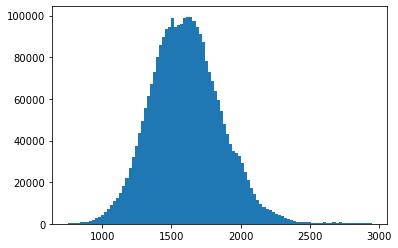

In [4]:
bins = create_bins(750, 2950, 100)
bins = np.array(bins)
hist_bins = np.concatenate([bins[:, 0], [2950]])
points, counts = openPickle('Data/FICS/2019/Histogram Count Data')
a = plt.hist(points, bins = hist_bins, weights = counts, density = False)

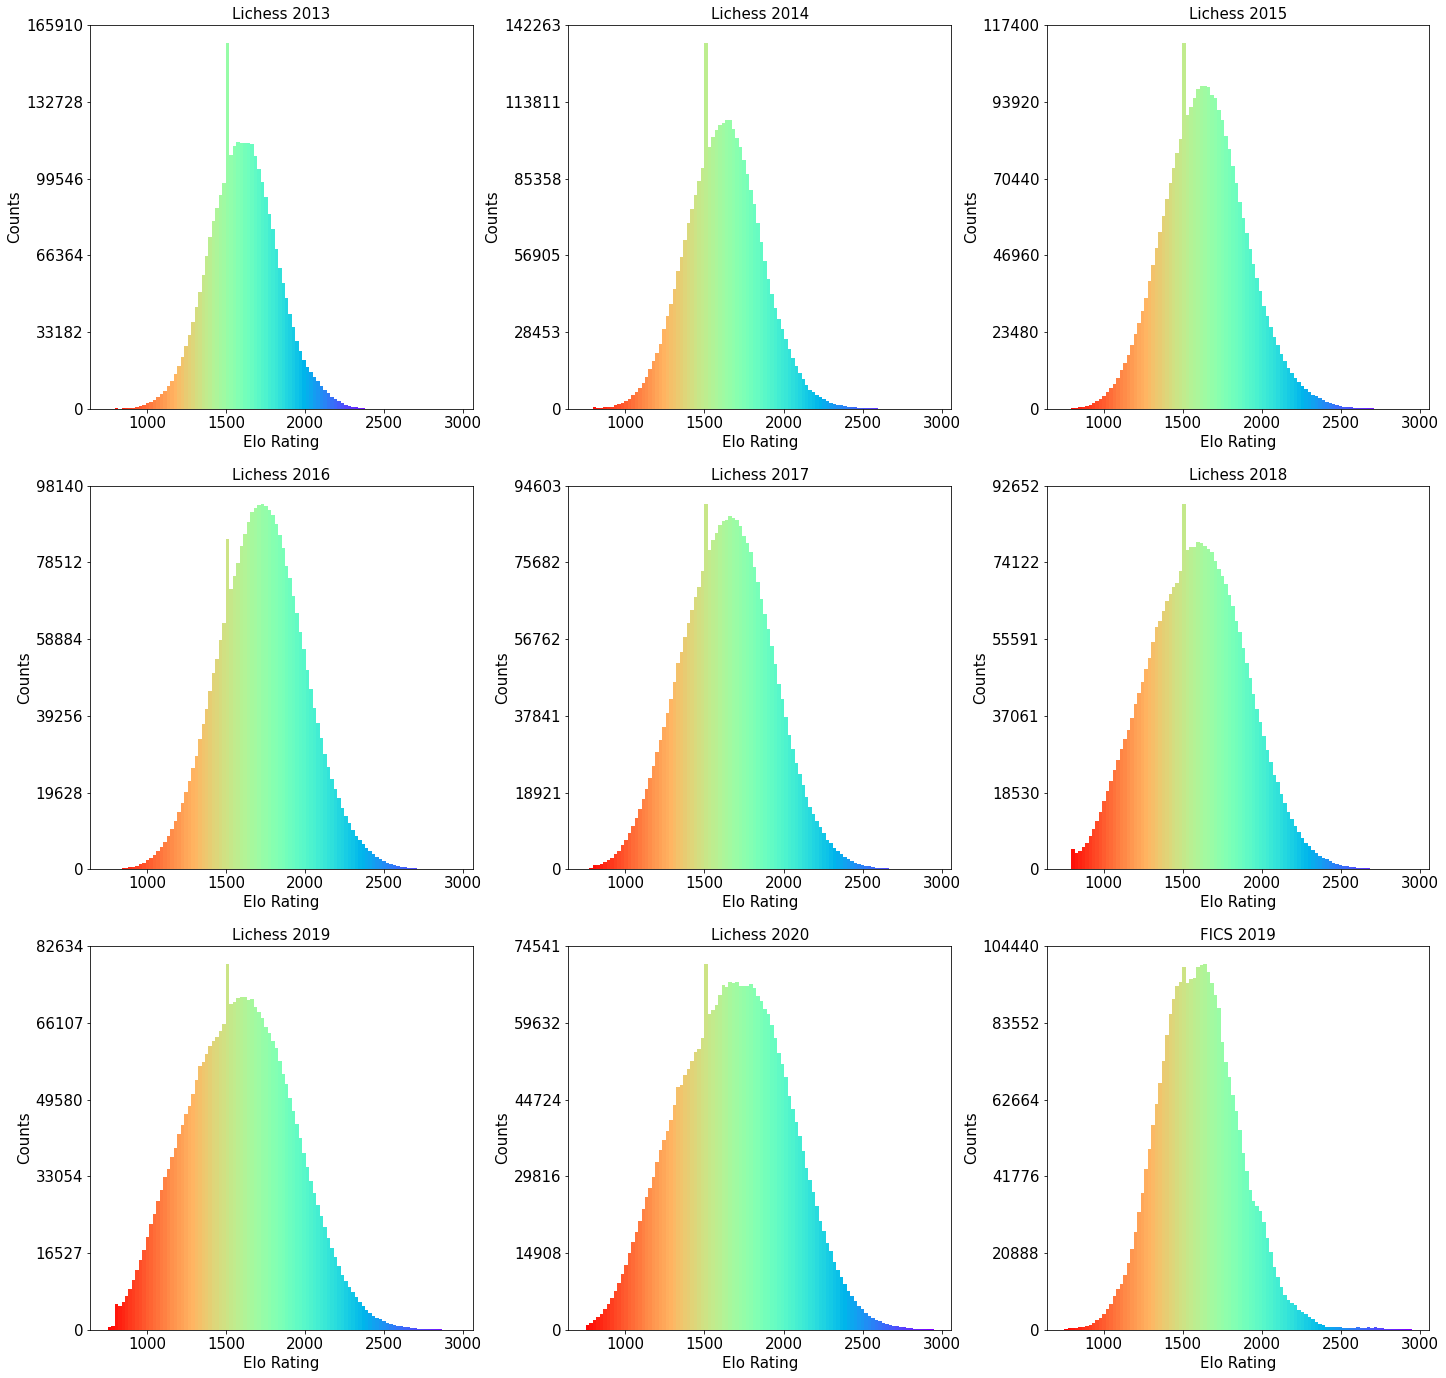

In [254]:
bins = create_bins(750, 2950, 100)
bins = np.array(bins)
hist_bins = np.concatenate([bins[:, 0], [2950]])
cmap = cm.get_cmap('rainbow')
fontsize = 15


fig, ax = plt.subplots(3, 3, figsize = (24, 24))
plt.subplots_adjust(wspace = 0.25)
for i in range(3):
    for j in range(3):
        year = 2013 + 3 * i + j
        
        if i == 2 and j == 2:
            path = 'Data/FICS/2019/Histogram Count Data'
            title = 'FICS 2019'
            
        else:
            path = 'Data/' + str(year) + '/Histogram Count Data'
            title = 'Lichess ' + str(year)
            
        points, counts = openPickle(path)
        out_count, bins, patches = ax[i][j].hist(points, bins = hist_bins, weights = counts, color = 'orange')
        out_count = out_count / np.sum(out_count)
        ax[i][j].set_title(title, fontsize = fontsize)
        ax[i][j].set_xlabel('Elo Rating', fontsize = fontsize)
        ax[i][j].set_ylabel('Counts', fontsize = fontsize)
#         ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), fontsize = 15)
        ax[i][j].tick_params(axis = 'x', labelsize = fontsize)
        ax[i][j].tick_params(axis = 'y', labelsize = fontsize)
        ylim = ax[i][j].get_ylim()
        ax[i][j].set_yticks(np.linspace(0, ylim[1], 6))
        
        # Set face colour
        thresh = 1e-5
        aranger = np.arange(np.sum(out_count >= thresh))
        aranger = aranger / len(aranger)
        counter = len(aranger) - 1
        for idx, patch in enumerate(patches):
            if out_count[idx] >= thresh:
                value = aranger[counter]
                plt.setp(patch, 'facecolor', cmap(value))
                counter -= 1

In [255]:
fig.savefig('All Years and FICS Histogram.pdf', dpi = 200, bbox_inches = 'tight')

## 2. Payoff matrix size experiment

In [273]:
def plot_nash_clusters(elo_data, title, xlim = None, ylim = None, ax = None, cmap = None, fontsize = 15, size = 2000):
    if ax == None:
        if cmap is None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], color = 'darkviolet')
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))
        plt.title(title)
        plt.ylabel('RPP Mean Win-rate')
        plt.xlabel('Cluster Size')
        
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], color = 'darkviolet')
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))

        ax.set_title(title, fontsize = fontsize)
        ax.set_ylabel('RPP Mean Win-rate', fontsize = fontsize)
        ax.set_xlabel('Cluster Size', fontsize = fontsize)
        ax.tick_params(axis = 'x', labelsize = fontsize)
        ax.tick_params(axis = 'y', labelsize = fontsize)
        
        
        if size <= 100:
            ax.set_xticks([0, 1, 2, 3, 4, 5])
            
        if size >= 1500:
            xlim = ax.get_xlim()
            ax.set_xticks(np.linspace(0, xlim[1], 6).astype('int64'))
        
        
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        
    return None

class NashCluster():
    
    def __init__(self, strat_payoffs, ori_idx, pvect):
        self.size = strat_payoffs.shape[0]
        self.payoffs = strat_payoffs
        self.strat_idx = ori_idx
        self.probability = pvect
        
    def computeRPS(self):
        return None

def compute_RPP(nc1, nc2, payoff):
    p_vect1 = np.zeros(payoff.shape[0]); p_vect2 = np.zeros(payoff.shape[0])
    
    p_vect1[nc1.strat_idx] = nc1.probability; p_vect2[nc2.strat_idx] = nc2.probability
    return (p_vect1.reshape(1, -1) @ payoff @ p_vect2.reshape(-1, 1)).item()

def generate_RPP_data(nash_clusters, payoff):
    data_tuples_rpp = []; n_nc = len(nash_clusters); data_tuples_rpp_sign = []; rpp_mat = np.zeros((n_nc, n_nc))
    for i, nc_i in enumerate(nash_clusters):
        rpp_sum = 0; rpp_sign_sum = 0
        for j, nc_j in enumerate(nash_clusters):
            if i != j:
                rpp = compute_RPP(nc_i, nc_j, payoff)
                rpp_mat[i,j] = rpp
                rpp_sum += rpp
                rpp_sign_sum += 1 * (rpp >= 0)

        rpp_sum = rpp_sum / n_nc; rpp_sign_sum = rpp_sign_sum / (n_nc - 1)

        data_tuples_rpp.append([int(nc_i.size), rpp_sum])
        data_tuples_rpp_sign.append([int(nc_i.size), rpp_sign_sum])

    return np.array(data_tuples_rpp), np.array(data_tuples_rpp_sign), rpp_mat

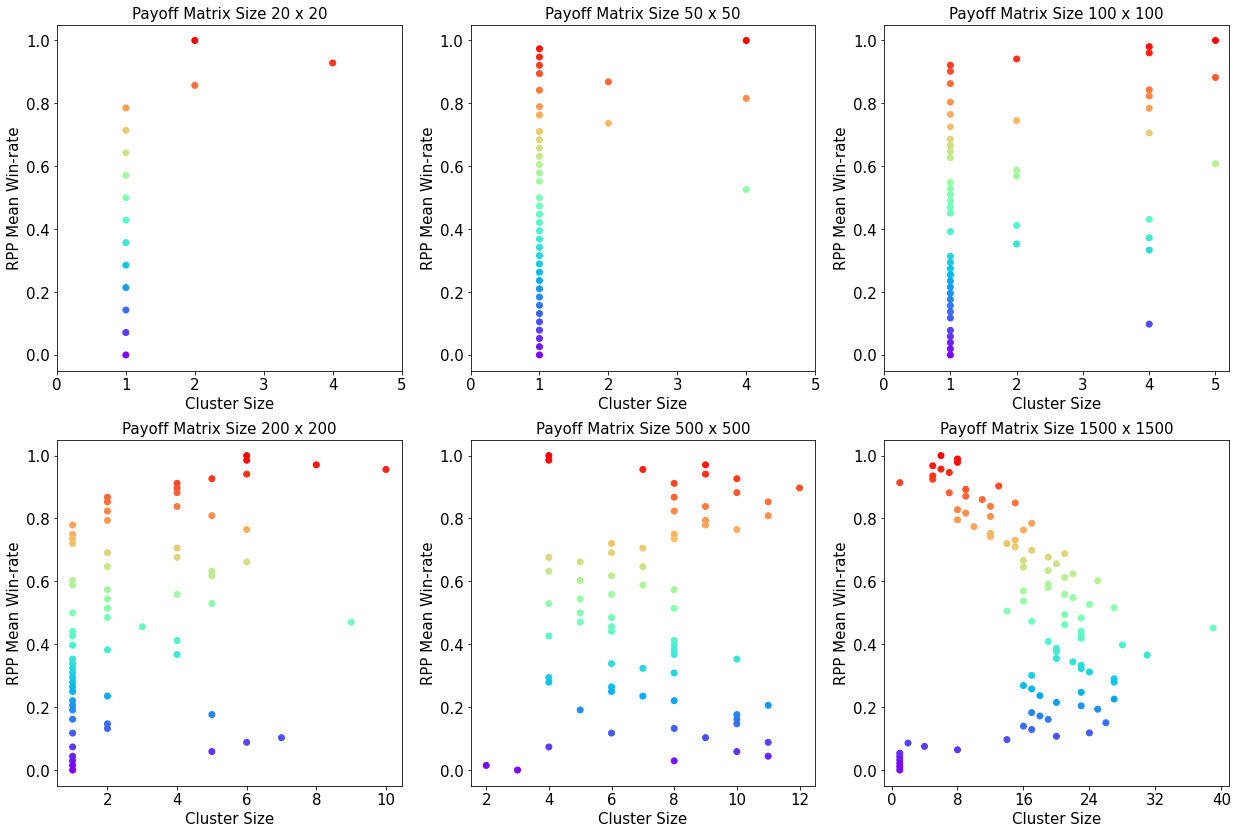

In [274]:
sizes = [20, 50, 100, 200, 500, 1500]
path = 'Data/2020/2020 Payoff Matrix Size Data'
results_dict = openPickle(path)
cmap = cm.get_cmap('rainbow')
fig2, ax2 = plt.subplots(2, 3, figsize = (21, 14))


for idx, size in enumerate(sizes):
    r = idx // 3; c = idx % 3 
    title = 'Payoff Matrix Size '+ str(size) + ' x '+ str(size)
    payoff, nash_clusters = results_dict[size]
    _, data, _ = generate_RPP_data(nash_clusters, payoff)
    plot_nash_clusters(data, title, ax = ax2[r][c], cmap = cmap, size = size)

In [275]:
fig2.savefig('Payoff Matrix Size Experiment.pdf', dpi = 200, bbox_inches = 'tight')

## 3. Nash Clusters for All Lichess and 2019 FICS

In [265]:
def affine_skewed_normal_loss(parameters, xdata, ydata):
    """
    parameters shape is [\mu, \sigma, \alpha, \a, \b]
    """
    mu, sigma, alpha, a, b = parameters
    
    # Compute the loss
    out = a * (sigma ** 2) * skewnorm.pdf(xdata, alpha, mu, sigma**2) + b
#     out = a * skewnorm.pdf(xdata, alpha, mu, sigma) + b
    loss = np.sum((out - ydata) ** 2)
    
    return loss

def affine_skewed_normal_pdf(parameters, xdata):
    mu, sigma, alpha, a, b = parameters
    out = a * (sigma ** 2) * skewnorm.pdf(xdata, alpha, mu, sigma**2) + b
#     out = a * skewnorm.pdf(xdata, alpha, mu, sigma) + b
    return out

def fit_skewed_normal(init, xdata, ydata):
    bnds = [(None, None), (1e-15, None), (None, None), (None, None), (None, None)]
    results = minimize(affine_skewed_normal_loss, init, args = (xdata, ydata), bounds = bnds, tol = 1e-8)
    return results.x

def plot_nash_clusters_with_curve(elo_data, title, lb, ub, seed = 88, ax = None, init_params = None, cmap = None, fontsize = 15):
    if ax == None:
        if cmap == None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))
        plt.title(title)
        plt.ylabel('RPP Mean Win-rate')
        plt.xlabel('Cluster Size')
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))

        ax.set_title(title, fontsize = fontsize)
        ax.set_ylabel('RPP Mean Win-rate', fontsize = fontsize)
        ax.set_xlabel('Cluster Size', fontsize = fontsize)
        ax.tick_params(axis = 'x', labelsize = fontsize)
        ax.tick_params(axis = 'y', labelsize = fontsize)
        
        xlim = ax.get_xlim()
        ax.set_xticks(np.linspace(0, xlim[1], 6).astype('int64'))
        
    
    np.random.seed(seed)
    y_data = elo_data[:, 0]; x_data = elo_data[:, 1]
    init = np.random.uniform(0, 100, size = (5))
    
    
    if init_params is not None:
        params = init_params
    else:
        params = fit_skewed_normal(init, x_data, y_data)

    inputs = np.linspace(lb, ub, 1000)
    outputs = affine_skewed_normal_pdf(params, inputs)
    
    if ax == None:
        plt.plot(outputs, inputs, color = 'm')
    else:
        ax.plot(outputs, inputs, color = 'm')
    
    return params

array([ 4.45299491e-01,  5.80680371e-01, -3.52339782e-03,  7.12149636e+01,
       -4.49308145e+00])

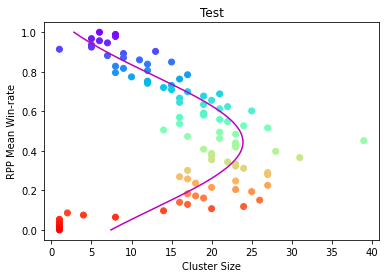

In [266]:
payoff = openPickle('Data/2020/ChessPayoff12 1500')
sign_data = openPickle('Data/2020/2020 rpp sign tuples 1500 12')
params = openPickle('Data/2020/2020 NC Plot Params 1500 12')
plot_nash_clusters_with_curve(sign_data, 'Test', 0, 1, init_params = params, cmap = cmap)

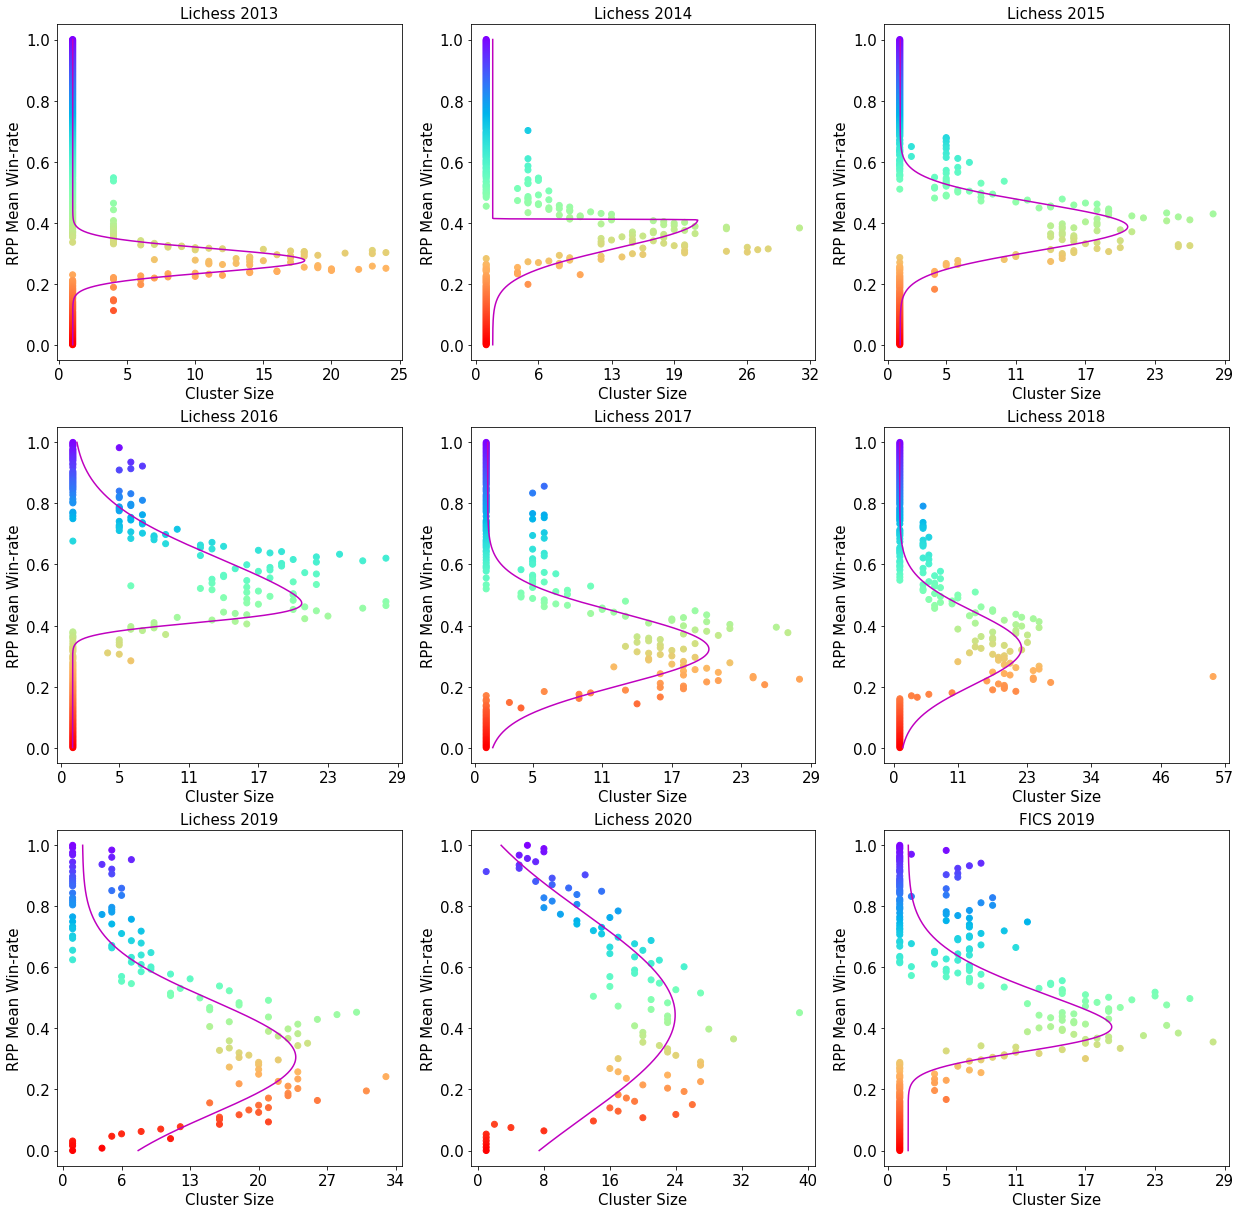

In [267]:
cmap = cm.get_cmap('rainbow')
fig3, ax3 = plt.subplots(3, 3, figsize = (21, 21))

for i in range(3):
    for j in range(3):
        year = 2013 + 3 * i + j
        
        if i == 2 and j == 2:
            path = 'Data/FICS/2019/'
            title = 'FICS 2019'
            
        else:
            path = 'Data/' + str(year) + '/'
            title = 'Lichess ' + str(year)
        
        if i == 2 and j == 2:
            data = openPickle(path + str(2019) + ' rpp sign tuples 1500 12')
            params = openPickle(path + str(2019) + ' NC Plot Params 1500 12')
            
        else:
            data = openPickle(path + str(year) + ' rpp sign tuples 1500 12')
            params = openPickle(path + str(year) + ' NC Plot Params 1500 12')
            
        _ = plot_nash_clusters_with_curve(data, title, 0, 1, init_params = params, cmap = cmap, ax = ax3[i][j])

In [268]:
fig3.savefig('Nash Clustering PD1 All.pdf', dpi = 200, bbox_inches = 'tight')

## Nash Clusters All Lichess and 2019 FICS Elo

In [276]:
def generate_elo_nc_data(nash_clusters, lower_bound, upper_bound, n):
    bins = create_bins(lower_bound, upper_bound, n)
    mid_bins = np.mean(np.array(bins), axis = 1)
    data = []
    
    for nc in nash_clusters:
        ori_idx = nc.strat_idx
        av_elo = np.mean(mid_bins[ori_idx])
        data.append([nc.size, av_elo])
    
    return np.array(data)

def plot_nash_clusters_with_curve_elo(elo_data, title, lb, ub, seed = 88, ax = None, init_params = None, cmap = None, fontsize = 15):
    if ax == None:
        if cmap == None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))
        plt.title(title)
        plt.ylabel('Average Elo Rating')
        plt.xlabel('Cluster Size')
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))

        ax.set_title(title, fontsize = fontsize)
        ax.set_ylabel('Average Elo Rating', fontsize = fontsize)
        ax.set_xlabel('Cluster Size', fontsize = fontsize)
        
        ax.tick_params(axis = 'x', labelsize = fontsize)
        ax.tick_params(axis = 'y', labelsize = fontsize)
        
        xlim = ax.get_xlim()
        ax.set_xticks(np.linspace(0, xlim[1], 6).astype('int64'))
        
    
    np.random.seed(seed)
    y_data = elo_data[:, 0]; x_data = elo_data[:, 1]
    init = np.random.uniform(0, 100, size = (5))
    
    if init_params is not None:
        init[0] = init_params[0]
        init[1] = init_params[1]
    
    params = fit_skewed_normal(init, x_data, y_data)

    inputs = np.linspace(lb, ub, 1000)
    outputs = affine_skewed_normal_pdf(params, inputs)
    
    outputs[outputs < 1] = 1
    
    if ax == None:
        plt.plot(outputs, inputs, color = 'm')
    else:
        ax.plot(outputs, inputs, color = 'm')
    
    return params

In [277]:
seed_list = [8888, 8888, 8888, 88888888, 88888888, 888888, 888888, 8888, 8]
to_init = [2020]
year_inits = dict()
year_inits[2020] = [1500, np.sqrt(500)] 

params_dict = dict()
nc_data_elo = dict()

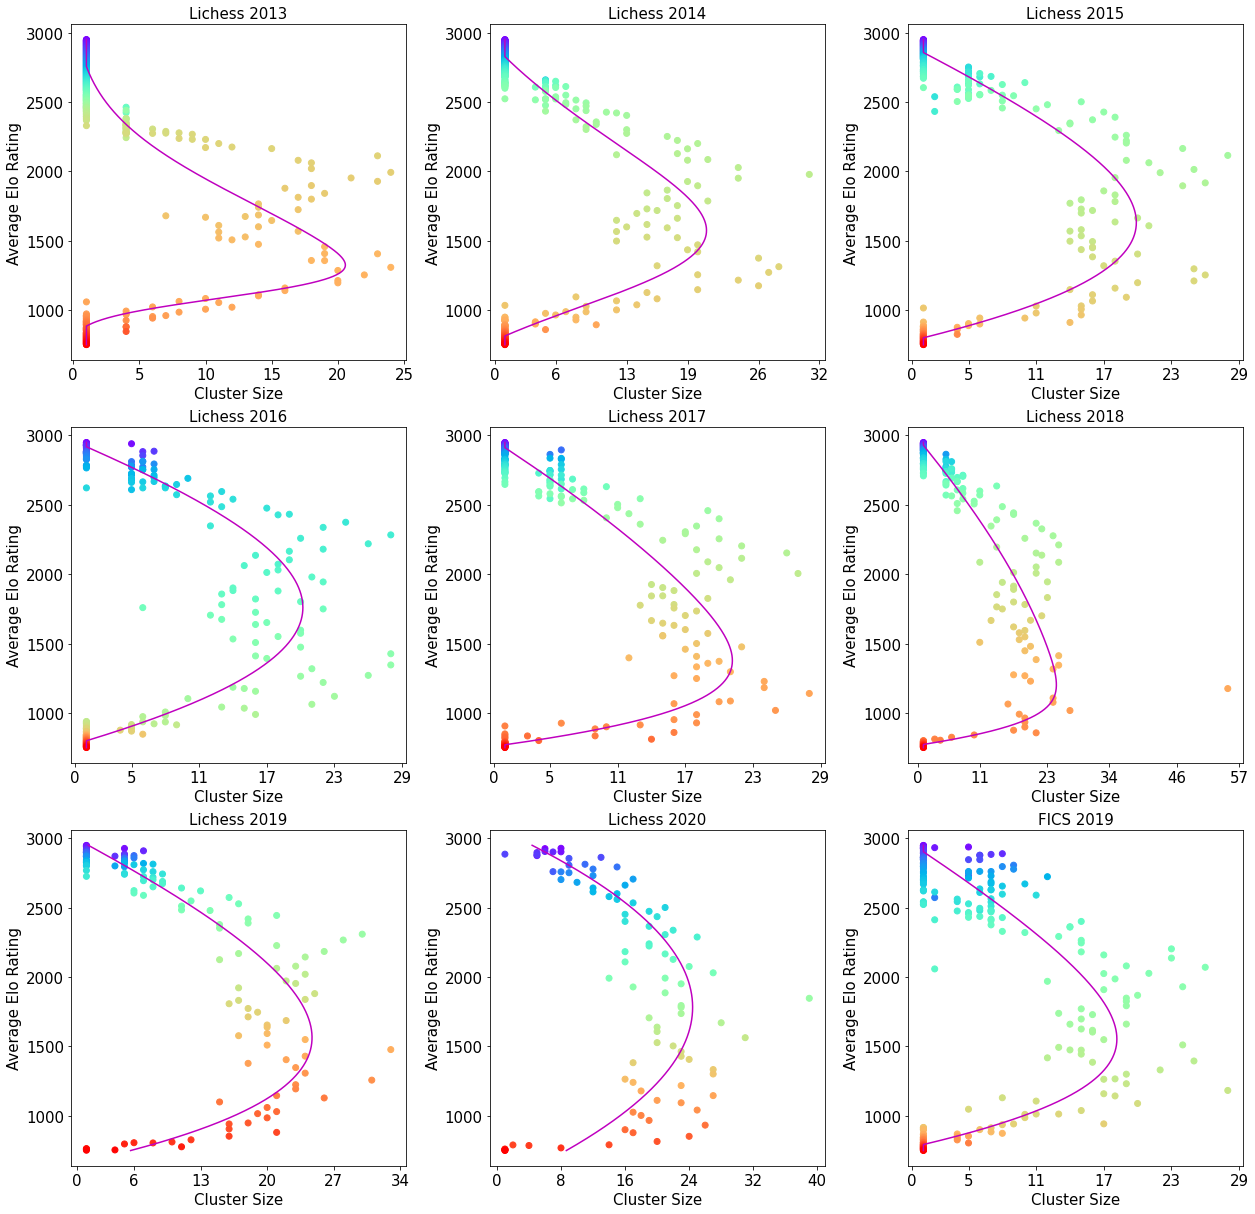

In [279]:
cmap = cm.get_cmap('rainbow')
fig4, ax4 = plt.subplots(3, 3, figsize = (21, 21))
plt.subplots_adjust(wspace = 0.25)
for i in range(3):
    for j in range(3):
        year = 2013 + 3 * i + j
        lin_idx = i * 3 + j
        
        if i == 2 and j == 2:
            path = 'Data/FICS/2019/'
            title = 'FICS 2019'
            
        else:
            path = 'Data/' + str(year) + '/'
            title = 'Lichess ' + str(year)
        
        if i == 2 and j == 2:
            nash_clusters = openPickle(path + '2019 Nash Clusters 1500 12')
        else:
            nash_clusters = openPickle(path + str(year) + ' Nash Clusters 1500 12')
        
        elo_data = generate_elo_nc_data(nash_clusters, 750, 2950, 1500)
        nc_data_elo[year] = elo_data
        
        if year in to_init:
            params = year_inits[year]
        else:
            params = None
            
        params = plot_nash_clusters_with_curve_elo(elo_data, title, 750, 2950, init_params = params, cmap = cmap, 
                                              ax = ax4[i][j], seed = seed_list[lin_idx])
        
        params_dict[year] = params

In [280]:
fig4.savefig('Nash Clustering PD2 All.pdf', dpi = 200, bbox_inches = 'tight')
savePickle(params_dict, 'Nash Cluster Plot Param Elo')
savePickle(nc_data_elo, 'Nash Cluster Plot Data Elo')

## 4. RPS cycles version 1

In [281]:
def generate_RPS_data(payoff):
    signed_payoff = 1 * (payoff > 0)
    strat_winrate = np.mean(payoff > 0, axis = 1)
    adj = signed_payoff @ signed_payoff @ signed_payoff
    data = np.concatenate([np.diag(adj).reshape(-1, 1), strat_winrate.reshape(-1, 1)], axis = 1)
    return data

In [282]:
def plot_rps(elo_data, title, ax = None, cmap = None, fontsize = 15):
    if ax == None:
        if cmap == None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))
        plt.title(title)
        plt.ylabel('Mean Win-rate')
        plt.xlabel('RPS Cycles')
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))

        ax.set_title(title, fontsize = fontsize)
        ax.set_ylabel('Mean Win-rate', fontsize = fontsize)
        ax.set_xlabel('RPS Cycles', fontsize = fontsize)
        
        ax.tick_params(axis = 'x', labelsize = fontsize)
        ax.tick_params(axis = 'y', labelsize = fontsize)
        
        xlim = ax.get_xlim()
        ax.set_xticks(np.linspace(0, xlim[1], 6))

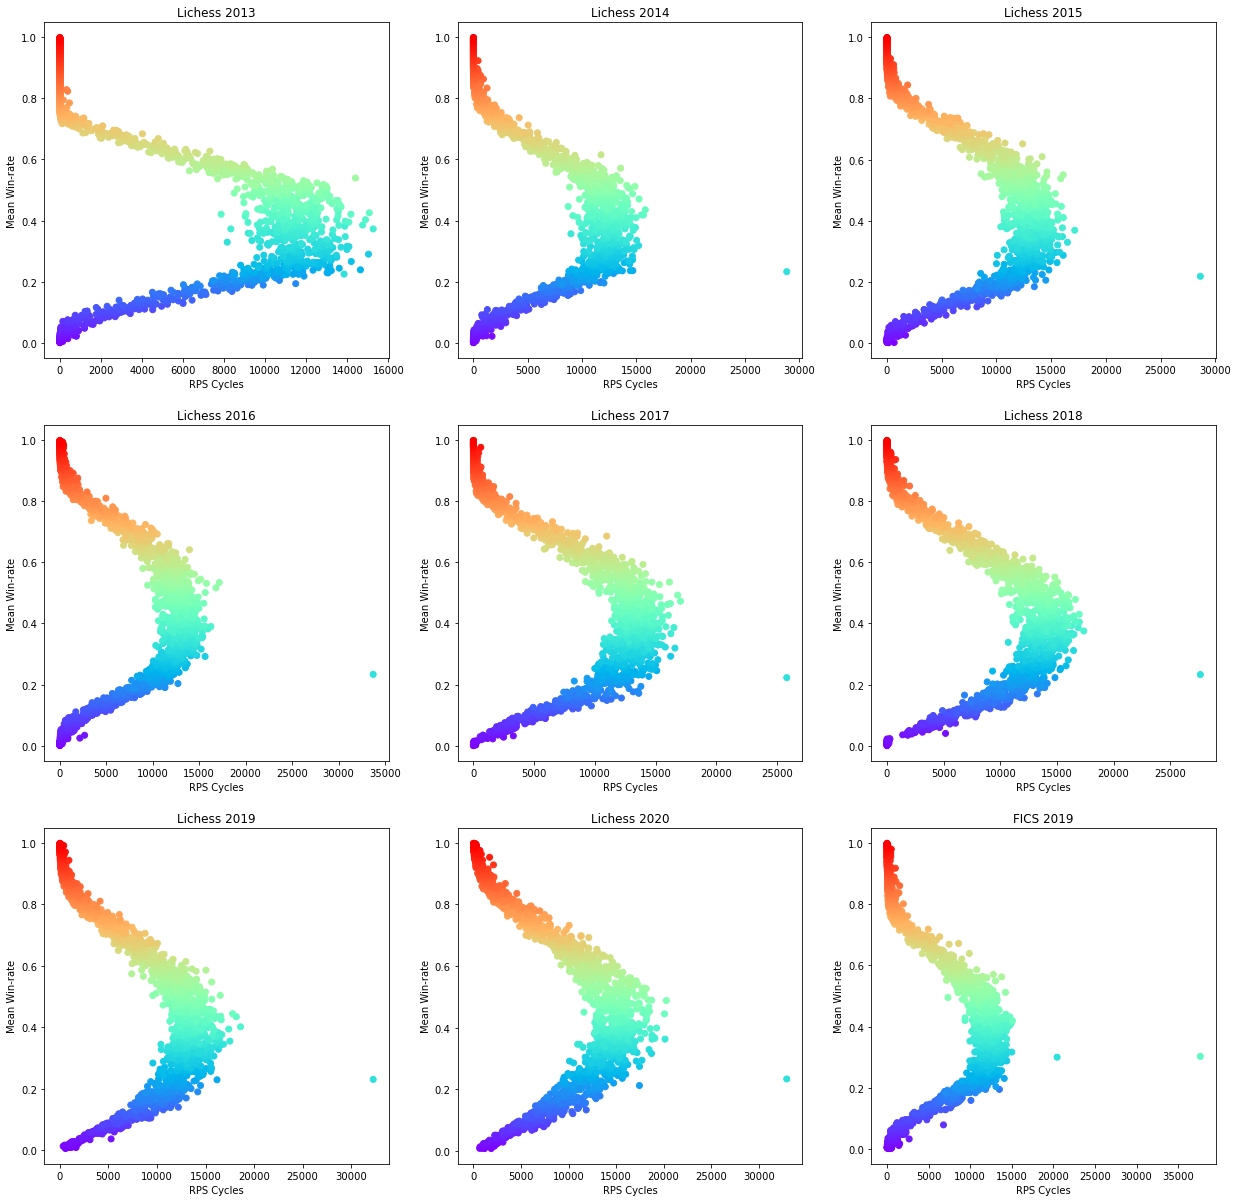

In [123]:
# NO NEED TO RUN THIS AGAIN IF REPLOT, JUST RUN THE ONE BELOW WITH SAVED DATA
cmap = cm.get_cmap('rainbow')
fig5, ax5 = plt.subplots(3, 3, figsize = (21, 21))
rps_data_dict = dict()
for i in range(3):
    for j in range(3):
        year = 2013 + 3 * i + j
        lin_idx = i * 3 + j
        
        if i == 2 and j == 2:
            path = 'Data/FICS/2019/'
            title = 'FICS 2019'
            
        else:
            path = 'Data/' + str(year) + '/'
            title = 'Lichess ' + str(year)
        
        if i == 2 and j == 2:
            payoff = openPickle(path + 'ChessPayoff12 1500')
        else:
            payoff = openPickle(path + 'ChessPayoff12 1500')
        
        rps_data = generate_RPS_data(payoff)
        rps_data_dict[year] = rps_data
        
        plot_rps(rps_data, title, ax = ax5[i][j], cmap = cmap)

In [124]:
savePickle(rps_data_dict, 'RPS Version 1 Plot Data')

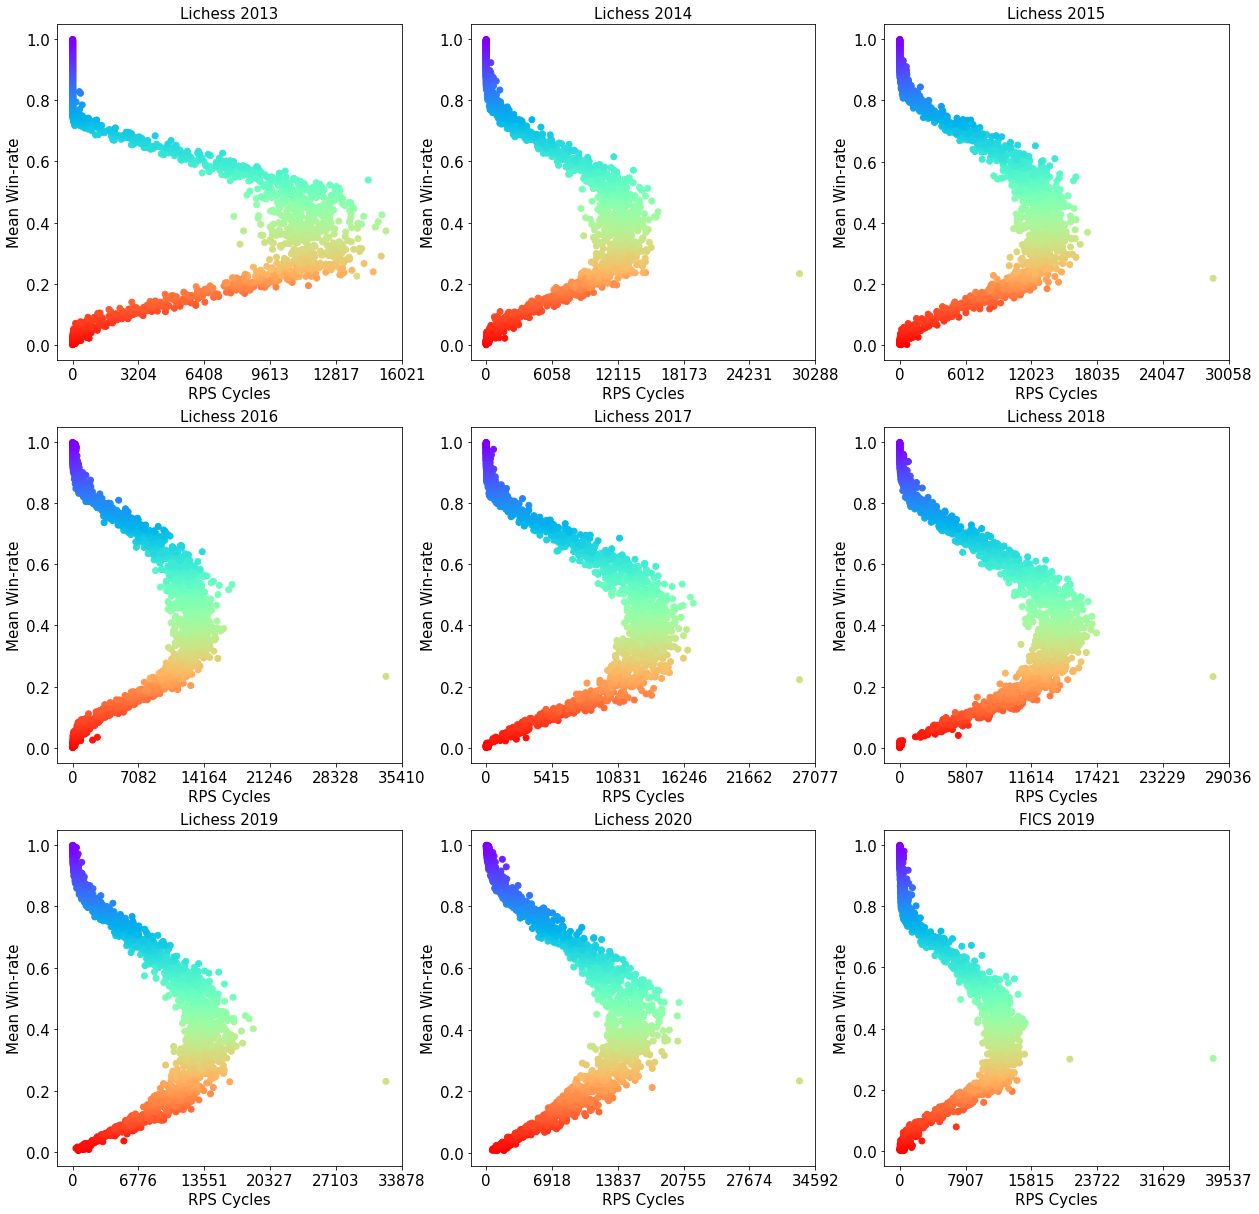

In [283]:
cmap = cm.get_cmap('rainbow')
fig5, ax5 = plt.subplots(3, 3, figsize = (21, 21))
rps_data_dict = openPickle('RPS Version 1 Plot Data')
for i in range(3):
    for j in range(3):
        year = 2013 + 3 * i + j
        
        if i == 2 and j == 2:
            title = 'FICS 2019'
        else:
            title = 'Lichess ' + str(year)
        
        rps_data = rps_data_dict[year]
        plot_rps(rps_data, title, ax = ax5[i][j], cmap = cmap)

In [284]:
fig5.savefig('RPS Plot Version 1.pdf', dpi = 200, bbox_inches = 'tight')

## RPS Cycles Version 2

In [285]:
def generate_RPS_data_elo(rps_data, bins):
    bins_array = np.array(bins)
    av_elo = np.mean(bins_array, axis = 1)
    data = np.concatenate([rps_data[:, 0].reshape(-1,1), av_elo.reshape(-1, 1)], axis = 1)
    return data

def plot_rps_elo(elo_data, title, ax = None, cmap = None, fontsize = 15):
    if ax == None:
        if cmap == None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))
        plt.title(title)
        plt.ylabel('Average Elo Rating')
        plt.xlabel('RPS Cycles')
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))

        ax.set_title(title, fontsize = 15)
        ax.set_ylabel('Average Elo Rating', fontsize = fontsize)
        ax.set_xlabel('RPS Cycles', fontsize = fontsize)
        
        ax.tick_params(axis = 'x', labelsize = fontsize)
        ax.tick_params(axis = 'y', labelsize = fontsize)
        
        xlim = ax.get_xlim()
        ax.set_xticks(np.linspace(0, xlim[1], 6))
    

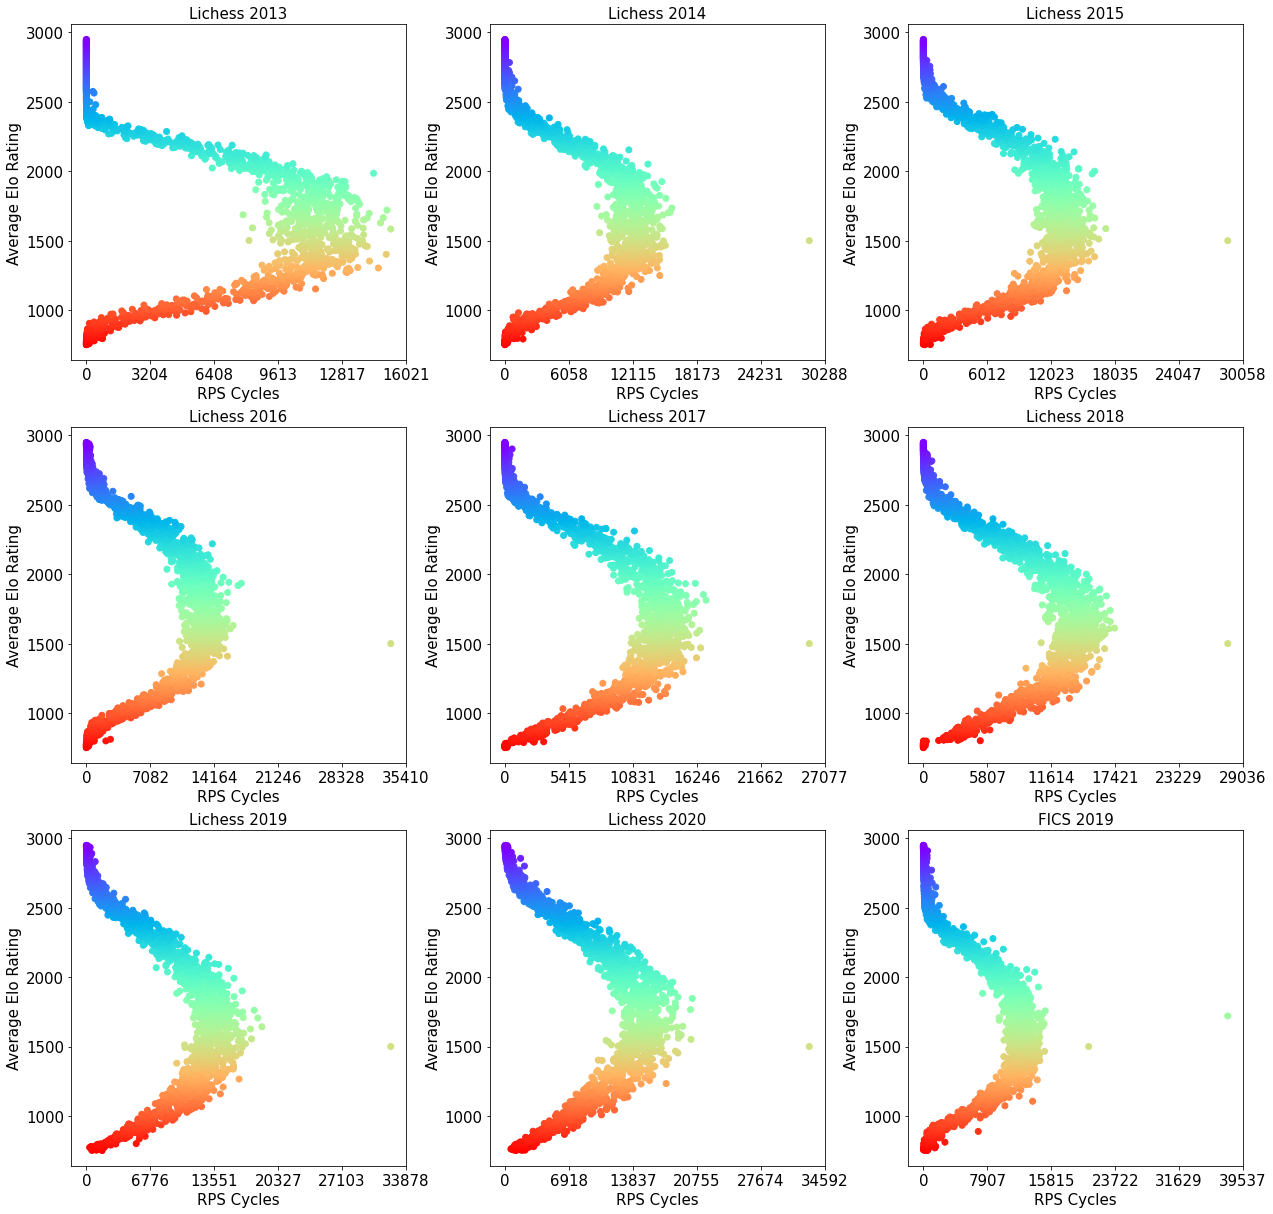

In [286]:
rps_data_elo_dict = dict()
cmap = cm.get_cmap('rainbow')
fig6, ax6 = plt.subplots(3, 3, figsize = (21, 21))
plt.subplots_adjust(wspace = 0.25)
rps_data_dict = openPickle('RPS Version 1 Plot Data')
bins = create_bins(750, 2950, 1500)
for i in range(3):
    for j in range(3):
        year = 2013 + 3 * i + j
        
        if i == 2 and j == 2:
            title = 'FICS 2019'
        else:
            title = 'Lichess ' + str(year)
        
        rps_data = rps_data_dict[year]
        rps_data_elo = generate_RPS_data_elo(rps_data, bins)
        rps_data_elo_dict[year] = rps_data_elo
        plot_rps_elo(rps_data_elo, title, ax = ax6[i][j], cmap = cmap)

In [287]:
fig6.savefig('RPS Plot Version 2.pdf', dpi = 200, bbox_inches = 'tight')

In [242]:
savePickle(rps_data_elo_dict, 'RPS Version 2 Plot Data')

## 7. RPS and Nash Version 2 Side by Side

In [360]:
def plot_nash_clusters_with_curve_elo_2(elo_data, title, lb, ub, seed = 88, ax = None, init_params = None, cmap = None):
    if ax == None:
        if cmap == None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))
        plt.title(title)
        plt.ylabel('Average Elo Rating')
        plt.xlabel('Cluster Size')
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))

        ax.set_title(title, fontsize = 15)
        ax.set_ylabel('Average Elo Rating', fontsize = 15)
        ax.set_xlabel('Cluster Size', fontsize = 15)
        
        ax.tick_params(axis = 'x', labelsize = 15)
        ax.tick_params(axis = 'y', labelsize = 15)
        
        xlim = ax.get_xlim()
        ax.set_xticks(np.linspace(0, xlim[1], 6).astype('int64'))
    
    np.random.seed(seed)
    y_data = elo_data[:, 0]; x_data = elo_data[:, 1]
    init = np.random.uniform(0, 100, size = (5))
    
#     if init_params is not None:
#         init[0] = init_params[0]
#         init[1] = init_params[1]
    
#     params = fit_skewed_normal(init, x_data, y_data)

    if init_params is not None:
        params = init_params
    else:
        params = fit_skewed_normal(init_params, x_data, y_data)

    inputs = np.linspace(lb, ub, 1000)
    outputs = affine_skewed_normal_pdf(params, inputs)
    
    outputs[outputs < 1] = 1
    
    if ax == None:
        plt.plot(outputs, inputs, color = 'm')
    else:
        ax.plot(outputs, inputs, color = 'm')
    
    return params

def plot_rps_elo(elo_data, title, ax = None, cmap = None, fontsize = 15):
    if ax == None:
        if cmap == None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))
        plt.title(title)
        plt.ylabel('Average Elo Rating')
        plt.xlabel('RPS Cycles')
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))

        ax.set_title(title, fontsize = 15)
        ax.set_ylabel('Average Elo Rating', fontsize = fontsize)
        ax.set_xlabel('RPS Cycles', fontsize = fontsize)
        
        ax.tick_params(axis = 'x', labelsize = fontsize)
        ax.tick_params(axis = 'y', labelsize = fontsize)
        
        xlim = ax.get_xlim()
        ax.set_xticks(np.linspace(0, xlim[1], 6))

In [68]:
nc_elo_data = openPickle("Nash Cluster Plot Data Elo")
elo_param_dict = openPickle("Nash Cluster Plot Param Elo")
rps_data_elo_dict = openPickle("RPS Version 2 Plot Data")

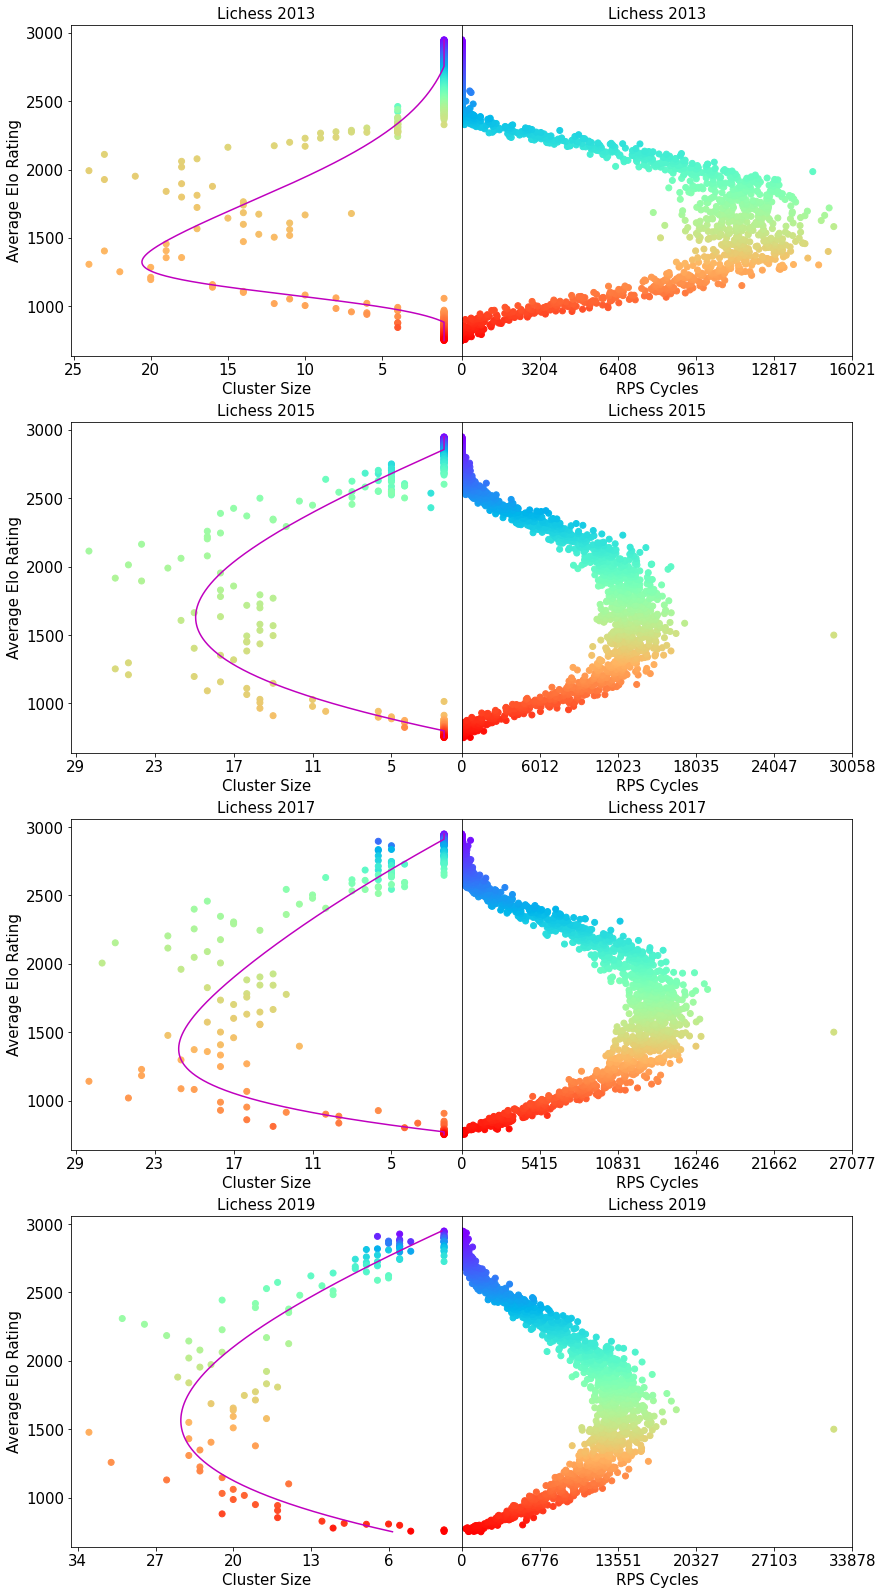

In [361]:
# Histogram and spinning top in one plot
lb = 750; ub = 2950; n = 1500
bins = create_bins(lb ,ub , n)
cmap = cm.get_cmap('rainbow')

fig7, ax7 = plt.subplots(4, 2, figsize = (14, 28))
plt.subplots_adjust(wspace = 0)
years = [2013, 2015, 2017, 2019]
for i in range(4):
    year = years[i]
    title = 'Lichess ' + str(year)
    
    # Nash Cluster
    elo_data = nc_elo_data[year]
    param = elo_param_dict[year]
    _ = plot_nash_clusters_with_curve_elo_2(elo_data, title, 750, 2950, cmap = cmap, 
                                            init_params = param, ax = ax7[i][0])
    
    
    # Flip the plot
    ticks = ax7[i][0].get_xticks()
    ax7[i][0].set_xticks(ticks[ticks > 0])
    
    xlim = ax7[i][0].get_xlim()
    ax7[i][0].set_xlim(xlim[1], xlim[0])
    
    # RPS Cycles
    rps_data_elo = rps_data_elo_dict[year]
    plot_rps_elo(rps_data_elo, title, ax = ax7[i][1], cmap = cmap)
        
    # Adjust the labellings
    ax7[i][1].set_ylabel('')
    ax7[i][1].set_yticks([])
    ax7[i][1].tick_params(labelleft = False)
    ax7[i][1].set_xlim(0)
    
    

In [362]:
fig7.savefig('Nash vs RPS Left Column.pdf', dpi = 200, bbox_inches = 'tight')

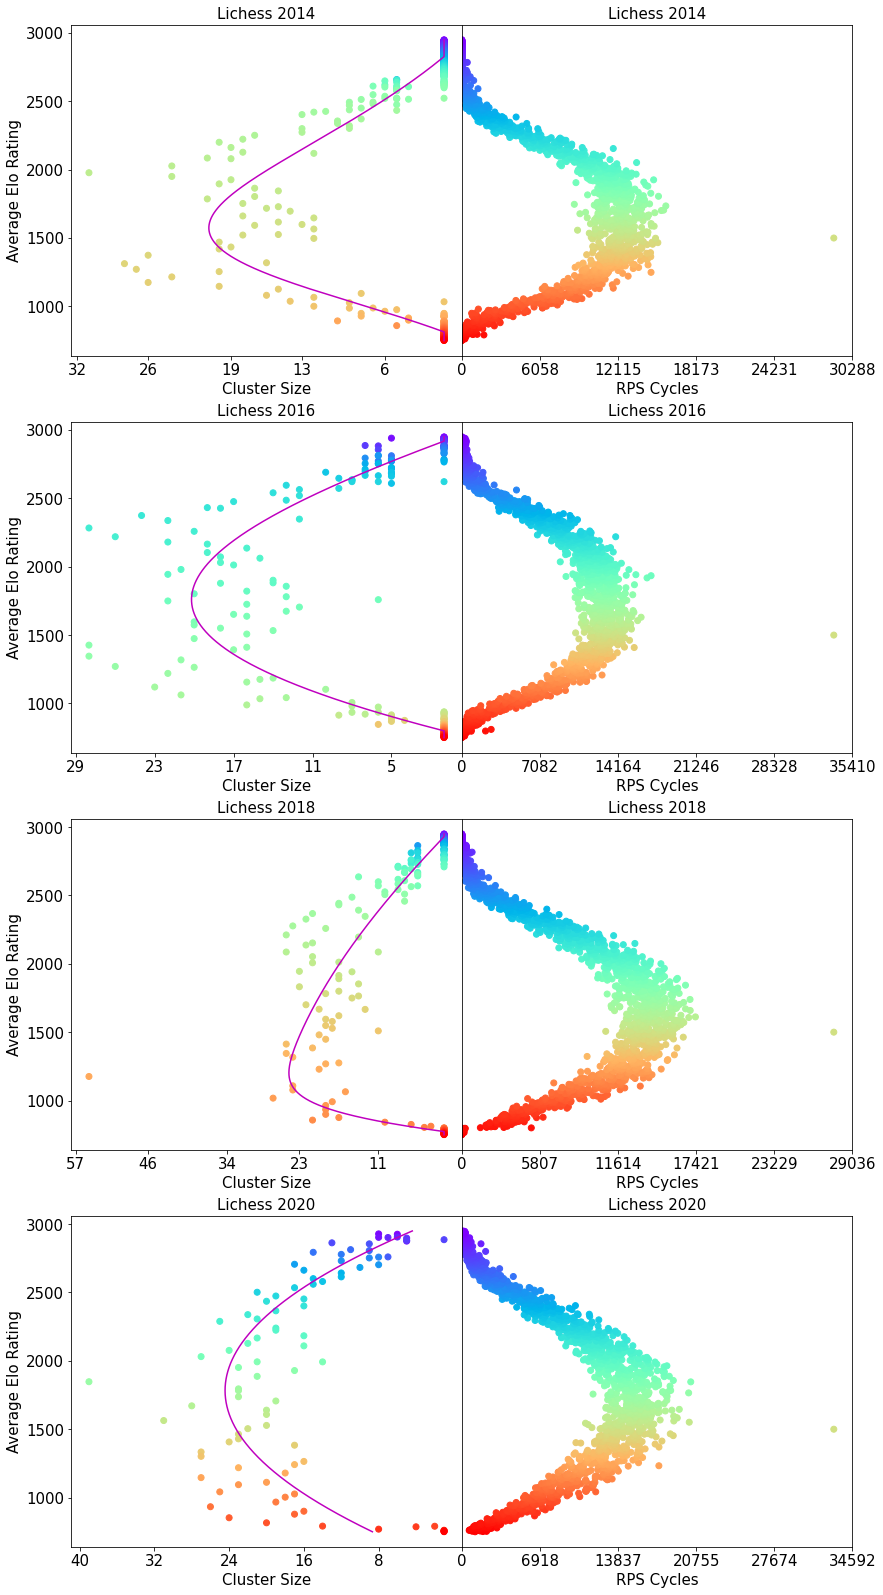

In [363]:
# Histogram and spinning top in one plot
lb = 750; ub = 2950; n = 1500
bins = create_bins(lb ,ub , n)
cmap = cm.get_cmap('rainbow')

fig7, ax7 = plt.subplots(4, 2, figsize = (14, 28))
plt.subplots_adjust(wspace = 0)
years = [2014, 2016, 2018, 2020]
for i in range(4):
    year = years[i]
    title = 'Lichess ' + str(year)
    
    # Nash Cluster
    elo_data = nc_elo_data[year]
    param = elo_param_dict[year]
    _ = plot_nash_clusters_with_curve_elo_2(elo_data, title, 750, 2950, cmap = cmap, 
                                            init_params = param, ax = ax7[i][0])
    
    
    # Flip the plot
    ticks = ax7[i][0].get_xticks()
    ax7[i][0].set_xticks(ticks[ticks > 0])
    
    xlim = ax7[i][0].get_xlim()
    ax7[i][0].set_xlim(xlim[1], xlim[0])
    
    # RPS Cycles
    rps_data_elo = rps_data_elo_dict[year]
    plot_rps_elo(rps_data_elo, title, ax = ax7[i][1], cmap = cmap)
        
    # Adjust the labellings
    ax7[i][1].set_ylabel('')
    ax7[i][1].set_yticks([])
    ax7[i][1].tick_params(labelleft = False)
    ax7[i][1].set_xlim(0)
    
    

In [364]:
fig7.savefig('Nash vs RPS Right Column.pdf', dpi = 200, bbox_inches = 'tight')

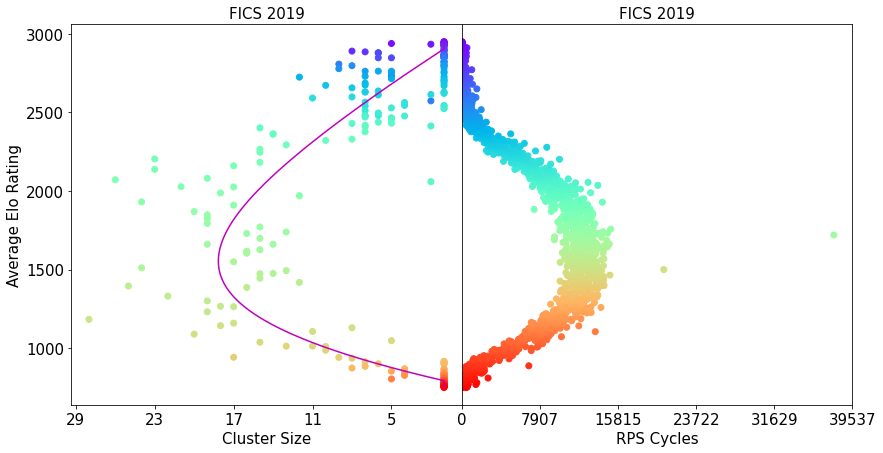

In [365]:
# Histogram and spinning top in one plot
lb = 750; ub = 2950; n = 1500
bins = create_bins(lb ,ub , n)
cmap = cm.get_cmap('rainbow')

fig7, ax7 = plt.subplots(1, 2, figsize = (14, 7))
plt.subplots_adjust(wspace = 0)
years = [2014, 2016, 2018, 2020]
for i in range(1):
    year = 2021
    title = 'FICS ' + str(2019)
    
    # Nash Cluster
    elo_data = nc_elo_data[year]
    param = elo_param_dict[year]
    _ = plot_nash_clusters_with_curve_elo_2(elo_data, title, 750, 2950, cmap = cmap, 
                                            init_params = param, ax = ax7[0])
    
    
    # Flip the plot
    ticks = ax7[0].get_xticks()
    ax7[0].set_xticks(ticks[ticks > 0])
    
    xlim = ax7[0].get_xlim()
    ax7[0].set_xlim(xlim[1], xlim[0])
    
    # RPS Cycles
    rps_data_elo = rps_data_elo_dict[year]
    plot_rps_elo(rps_data_elo, title, ax = ax7[1], cmap = cmap)
        
    # Adjust the labellings
    ax7[1].set_ylabel('')
    ax7[1].set_yticks([])
    ax7[1].tick_params(labelleft = False)
    ax7[1].set_xlim(0)
    
    

In [366]:
fig7.savefig('Nash vs RPS Last Image.pdf', dpi = 200, bbox_inches = 'tight')

## 8. Theoretical games

In [304]:
def plot_nash_clusters(elo_data, title, xlim = None, ylim = None, ax = None, cmap = None, fontsize = 15):
    if ax == None:
        if cmap is None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], color = 'darkviolet')
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))
        plt.title(title)
        plt.ylabel('RPP Mean Win-rate')
        plt.xlabel('Cluster Size')
        
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], color = 'darkviolet')
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))

        ax.set_title(title, fontsize = fontsize)
        ax.set_ylabel('RPP Mean Win-rate', fontsize = fontsize)
        ax.set_xlabel('Cluster Size', fontsize = fontsize)
        ax.tick_params(axis = 'x', labelsize = fontsize)
        ax.tick_params(axis = 'y', labelsize = fontsize)
        
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
            
#         xlim_new = ax.get_xlim()
#         ax.set_xticks(np.linspace(0, xlim_new[1], 5).astype('int64'))
        
        
    return None

class NashCluster():
    
    def __init__(self, strat_payoffs, ori_idx, pvect):
        self.size = strat_payoffs.shape[0]
        self.payoffs = strat_payoffs
        self.strat_idx = ori_idx
        self.probability = pvect
        
    def computeRPS(self):
        return None
    
def plot_rps(elo_data, title, xlim = None, ylim = None, ax = None, cmap = None, fontsize = 15):
    if ax == None:
        if cmap is None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], color = 'darkviolet')
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))
        plt.title(title)
        plt.ylabel('Mean Win-rate')
        plt.xlabel('RPS Cycles')
        
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], color = 'darkviolet')
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))

        ax.set_title(title, fontsize = fontsize)
        ax.set_ylabel('Mean Win-rate', fontsize = fontsize)
        ax.set_xlabel('RPS Cycles', fontsize = fontsize)
        ax.tick_params(axis = 'x', labelsize = fontsize)
        ax.tick_params(axis = 'y', labelsize = fontsize)
        
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
            
        xlim = ax.get_xlim()
        ax.set_xticks(np.linspace(0, xlim[1], 6))

In [290]:
# Disc Game: Use matrix from \ref[9]
payoff = openPickle('Disc Game Payoff 1500')
nash_clusters = openPickle('Disc Game Nash Clusters 1500')
rps_data = openPickle("Disc Game RPS Data 1500")

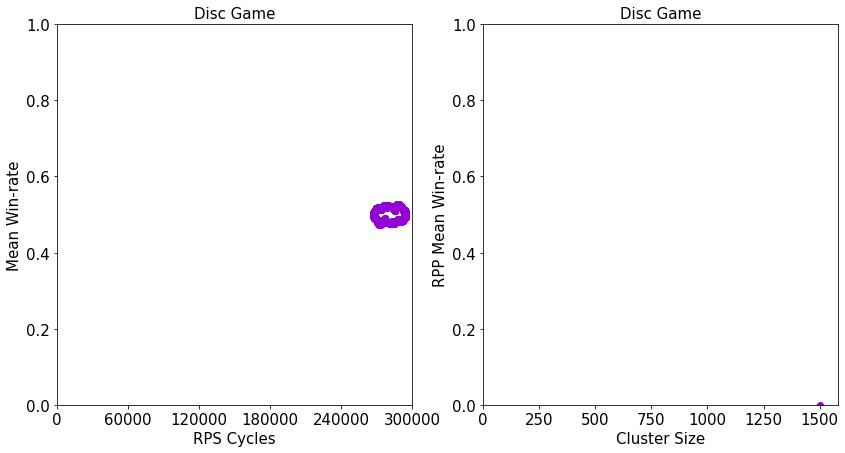

In [307]:
fig8, ax8 = plt.subplots(1, 2, figsize = (14, 7))
cmap = cm.get_cmap('rainbow')

plot_rps(rps_data, 'Disc Game', xlim = (0, 3e5), ylim = (0, 1), ax = ax8[0])
plot_nash_clusters(np.array([[nash_clusters[0].size, 0]]), 'Disc Game', xlim = (0, None), ylim = (0, 1), ax = ax8[1])

In [308]:
fig8.savefig('Disc Game Non-Transitivity.pdf', dpi = 200, bbox_inches = 'tight')

In [309]:
# Elo Game
nc_data = openPickle('Elo Game NC Data 1500')
rps_data = openPickle('Elo Game RPS Data 1500')

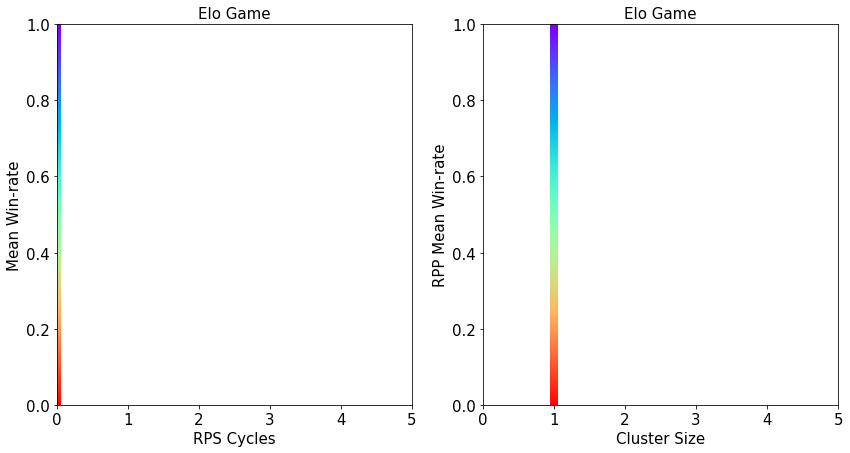

In [310]:
fig9, ax9 = plt.subplots(1, 2, figsize = (14, 7))
cmap = cm.get_cmap('rainbow')

plot_rps(rps_data, 'Elo Game', xlim =(0, 5), ylim = (0, 1), ax = ax9[0], cmap = cmap)
plot_nash_clusters(nc_data, 'Elo Game', xlim = (0, 5), ylim = (0, 1), ax = ax9[1], cmap = cmap)

In [311]:
fig9.savefig('Elo Game Non-Transitivity.pdf', dpi = 200, bbox_inches = 'tight')

## 10. Training Plots with Uniform Allocation

In [367]:
def plot_training(win_rates_results, title, ax, xlim = None, ylim = None, fontsize = 15, legendsize = 13, ncol = 1):
    ax.set_title(title, fontsize = fontsize)
    for pop_size in win_rates_results.keys():
        win_rates = win_rates_results[pop_size]
        ax.plot(np.arange(len(win_rates)), win_rates, label = str(pop_size))
        
    ax.set_xlabel('Iterations', fontsize = fontsize)
    ax.set_ylabel('Expected Average Payoff', fontsize = fontsize)
    leg = ax.legend(title = 'Population Size', fontsize = legendsize, loc = (.67, .265), ncol = ncol)
    leg.set_title('Population Size', prop={'size': legendsize})
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    ax.tick_params(axis = 'x', labelsize = fontsize)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    
    if ylim is not None:
        ax.set_ylim(ylim)
        
def plot_nash_clusters_with_curve(elo_data, title, lb, ub, seed = 88, ax = None, init_params = None, 
                                  fontsize = 15, cmap = None):
    if ax == None:
        if cmap == None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))
        plt.title(title)
        plt.ylabel('RPP Mean Win-rate')
        plt.xlabel('Cluster Size')
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))

        ax.set_title(title, fontsize = fontsize)
        ax.set_ylabel('RPP Mean Win-rate', fontsize = fontsize)
        ax.set_xlabel('Cluster Size', fontsize = fontsize)
        ax.tick_params(axis = 'x', labelsize = fontsize)
        ax.tick_params(axis = 'y', labelsize = fontsize)
        
        xlim = ax.get_xlim()
        ax.set_xticks(np.linspace(0, xlim[1], 6).astype('int64'))
    
    np.random.seed(seed)
    y_data = elo_data[:, 0]; x_data = elo_data[:, 1]
    init = np.random.uniform(0, 100, size = (5))
    
    
    if init_params is not None:
        params = init_params
    else:
        params = fit_skewed_normal(init, x_data, y_data)

    inputs = np.linspace(lb, ub, 1000)
    outputs = affine_skewed_normal_pdf(params, inputs)
    
    if ax == None:
        plt.plot(outputs, inputs, color = 'm')
    else:
        ax.plot(outputs, inputs, color = 'm')
    
    return params

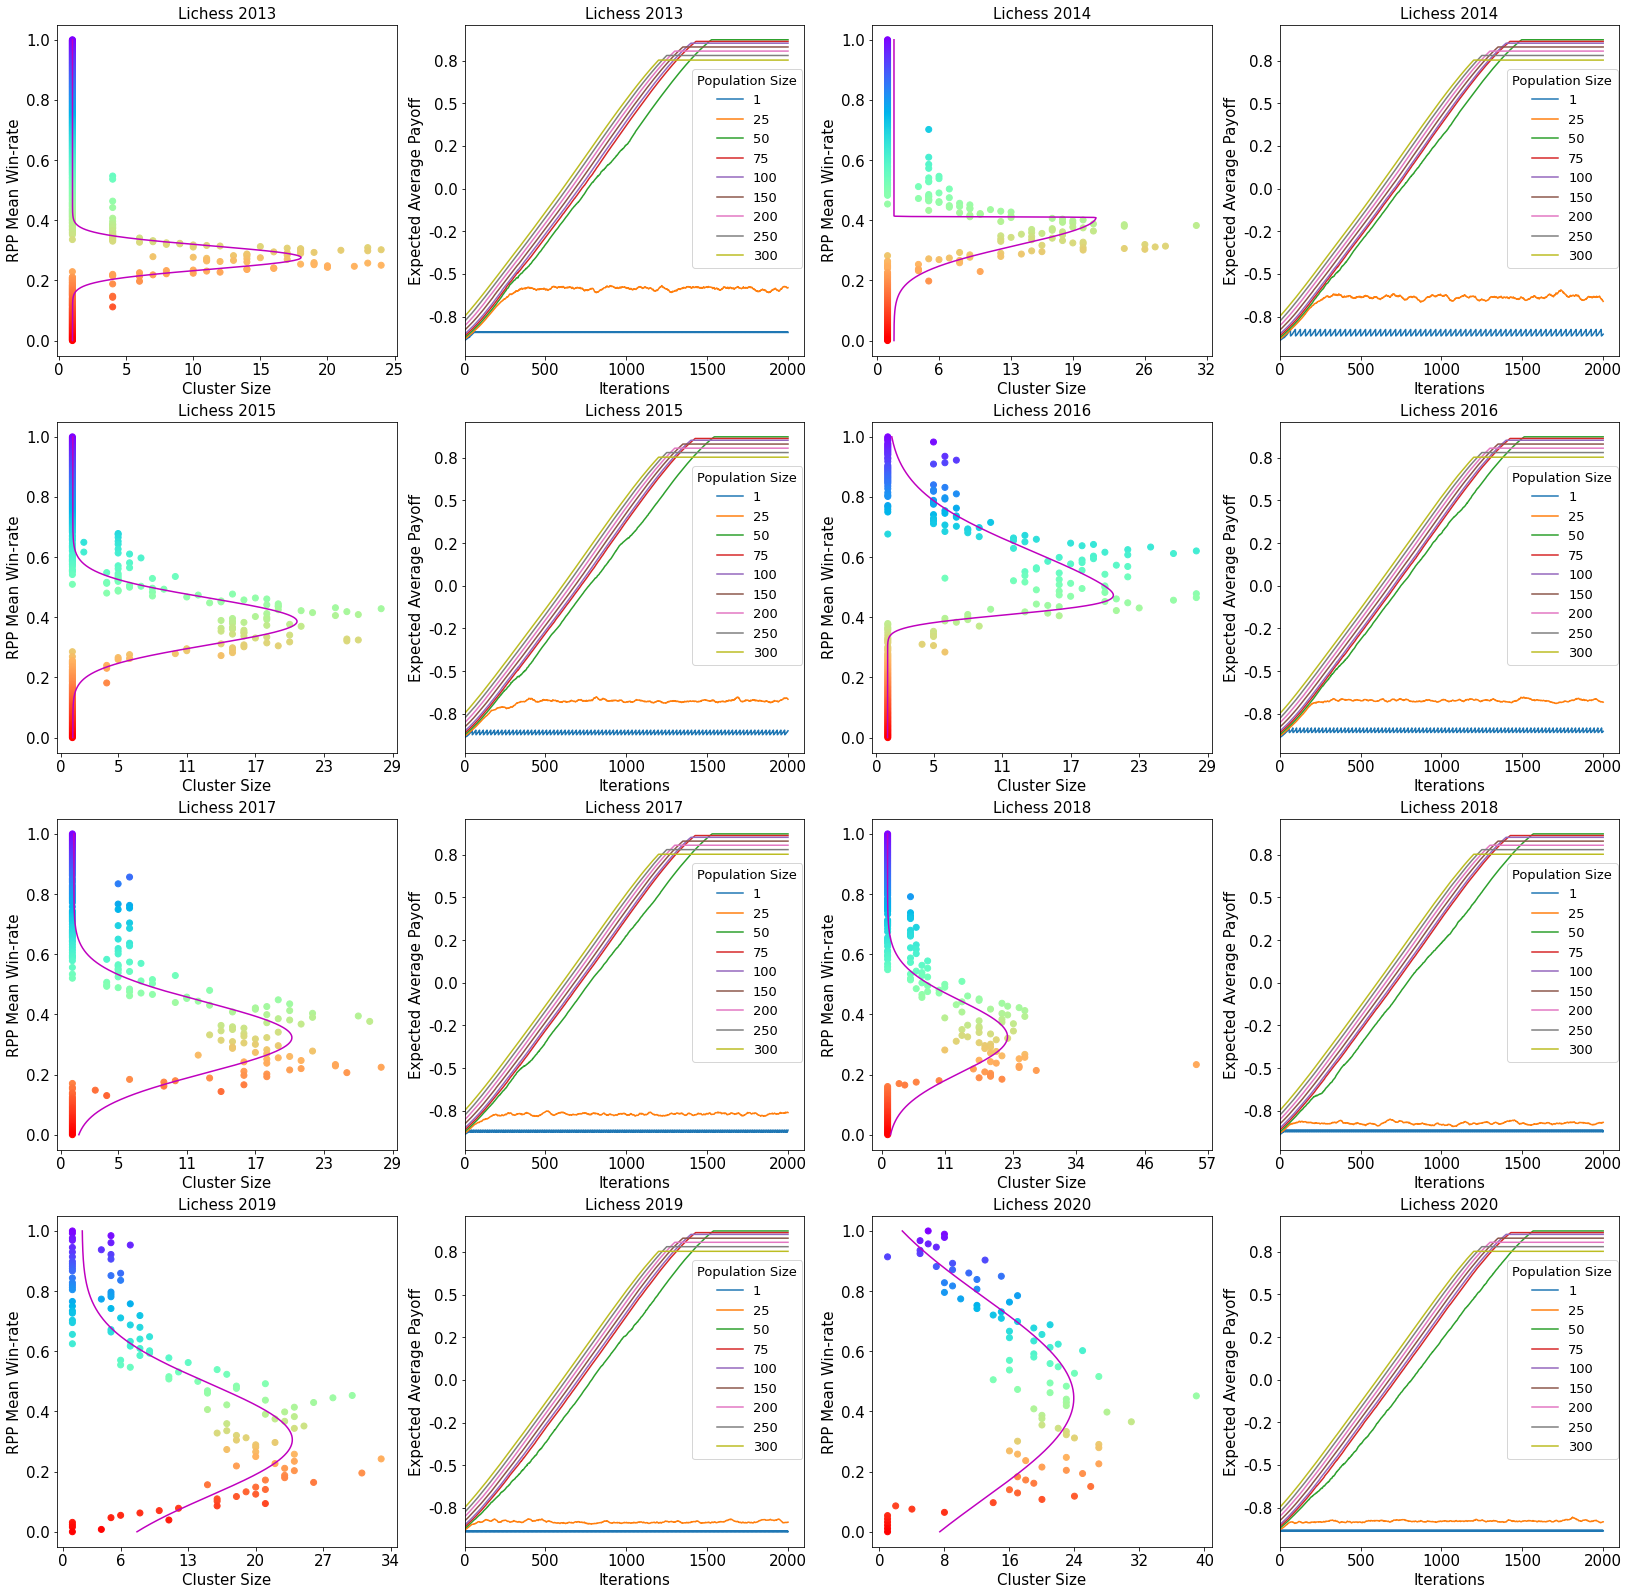

In [377]:
fig10, ax10 = plt.subplots(4, 4, figsize = (28, 28))
cmap = cm.get_cmap('rainbow')
# plt.subplots_adjust(wspace = .25)
for i in range(4):
    for j in range(4):
        year = 2013 + 2 * i + j // 2
        
        if j % 2 == 0:
            # Plot Nash Clusters
            if year == 2021:
                path = 'Data/FICS/2019/'
                title = 'FICS 2019'
                data = openPickle(path + str(2019) + ' rpp sign tuples 1500 12')
                params = openPickle(path + str(2019) + ' NC Plot Params 1500 12')
            else:
                path = 'Data/' + str(year) + '/'
                title = 'Lichess ' + str(year)
                data = openPickle(path + str(year) + ' rpp sign tuples 1500 12')
                params = openPickle(path + str(year) + ' NC Plot Params 1500 12')
                
            _ = plot_nash_clusters_with_curve(data, title, 0, 1, init_params = params, cmap = cmap, ax = ax10[i][j])
            
        else:
            # Plot FP
            if year == 2021:
                path = 'FICS 2019 Training Uniform'
                title = 'FICS 2019'
            else:
                path = 'Lichess ' + str(year) + ' Training Uniform'
                title = 'Lichess ' + str(year)


            win_rates_results = openPickle(path)
            plot_training(win_rates_results, title, ax10[i][j], xlim = (0, None))

In [378]:
fig10.savefig('FP Training Uniform Lichess.pdf', dpi = 200, bbox_inches = 'tight')

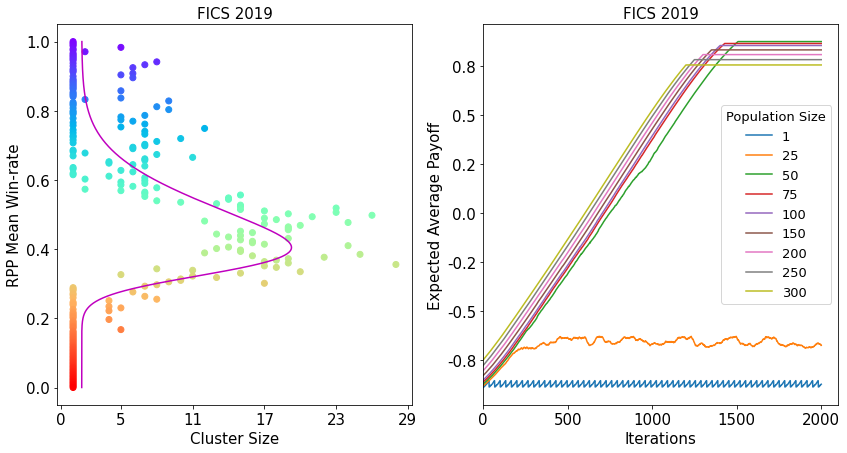

In [379]:
fig10, ax10 = plt.subplots(1, 2, figsize = (14, 7))
cmap = cm.get_cmap('rainbow')

for j in range(2):
    year = 2021

    if j % 2 == 0:
        # Plot Nash Clusters
        if year == 2021:
            path = 'Data/FICS/2019/'
            title = 'FICS 2019'
            data = openPickle(path + str(2019) + ' rpp sign tuples 1500 12')
            params = openPickle(path + str(2019) + ' NC Plot Params 1500 12')
        else:
            path = 'Data/' + str(year) + '/'
            title = 'Lichess ' + str(year)
            data = openPickle(path + str(year) + ' rpp sign tuples 1500 12')
            params = openPickle(path + str(year) + ' NC Plot Params 1500 12')

        _ = plot_nash_clusters_with_curve(data, title, 0, 1, init_params = params, cmap = cmap, ax = ax10[j])

    else:
        # Plot FP
        if year == 2021:
            path = 'FICS 2019 Training Uniform'
            title = 'FICS 2019'
        else:
            path = 'Lichess ' + str(year) + ' Training Uniform'
            title = 'Lichess ' + str(year)


        win_rates_results = openPickle(path)
        plot_training(win_rates_results, title, ax10[j], xlim = (0, None))

In [380]:
fig10.savefig('FP Training Uniform FICS.pdf', dpi = 200, bbox_inches = 'tight')

## 11. With Nash

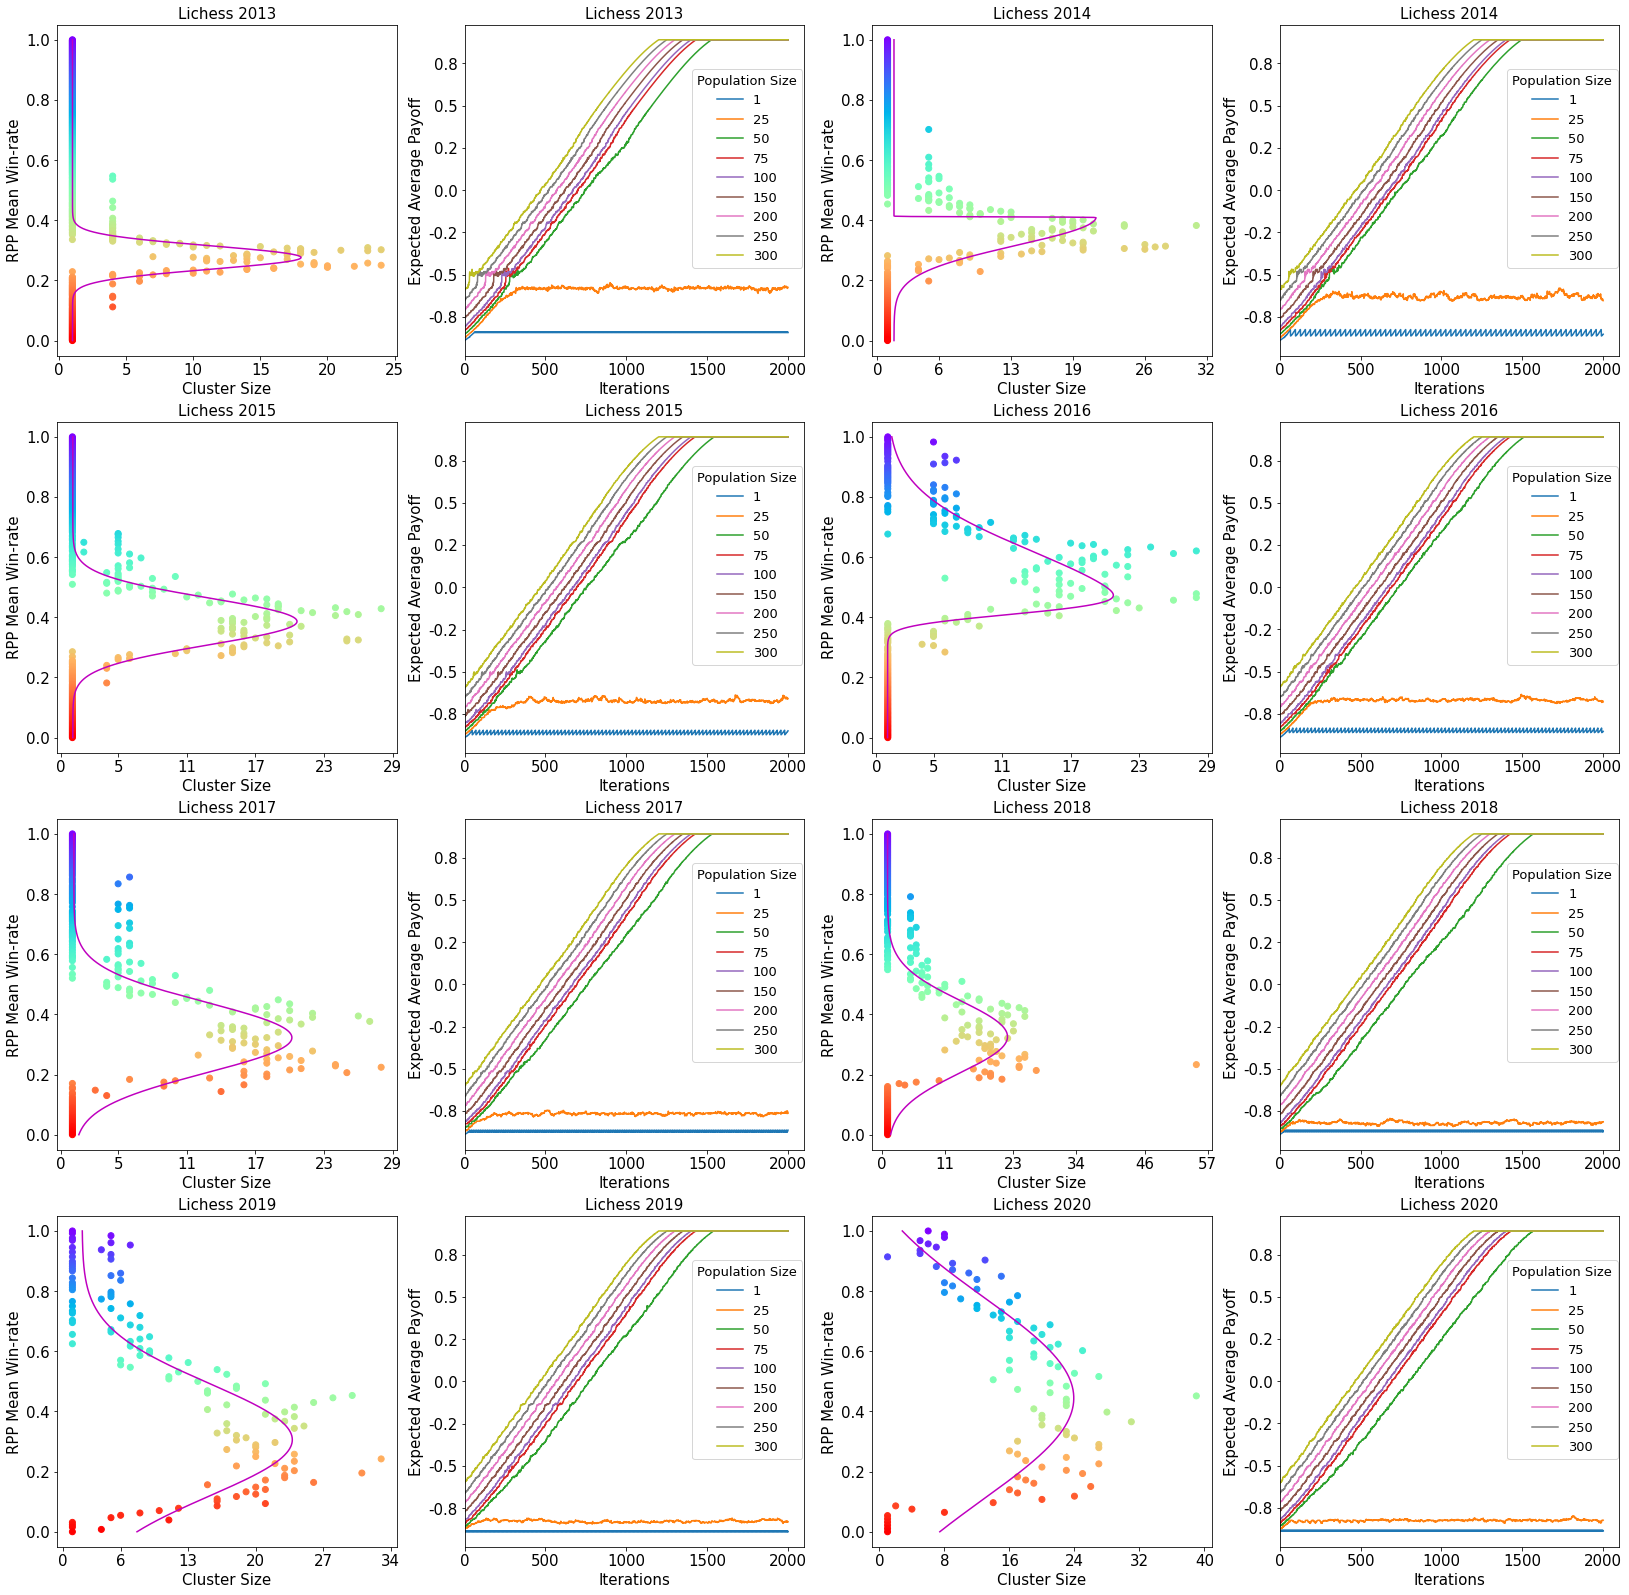

In [381]:
fig11, ax11 = plt.subplots(4, 4, figsize = (28, 28))
cmap = cm.get_cmap('rainbow')

for i in range(4):
    for j in range(4):
        year = 2013 + 2 * i + j // 2
        
        if j % 2 == 0:
            # Plot Nash Clusters
            if year == 2021:
                path = 'Data/FICS/2019/'
                title = 'FICS 2019'
                data = openPickle(path + str(2019) + ' rpp sign tuples 1500 12')
                params = openPickle(path + str(2019) + ' NC Plot Params 1500 12')
            else:
                path = 'Data/' + str(year) + '/'
                title = 'Lichess ' + str(year)
                data = openPickle(path + str(year) + ' rpp sign tuples 1500 12')
                params = openPickle(path + str(year) + ' NC Plot Params 1500 12')
                
            _ = plot_nash_clusters_with_curve(data, title, 0, 1, init_params = params, cmap = cmap, ax = ax11[i][j])
            
        else:
            # Plot FP
            if year == 2021:
                path = 'FICS 2019 Training Nash'
                title = 'FICS 2019'
            else:
                path = 'Lichess ' + str(year) + ' Training Nash'
                title = 'Lichess ' + str(year)


            win_rates_results = openPickle(path)
            plot_training(win_rates_results, title, ax11[i][j], xlim = (0, None))

In [382]:
fig11.savefig('FP Training Nash Lichess.pdf', dpi = 200, bbox_inches = 'tight')

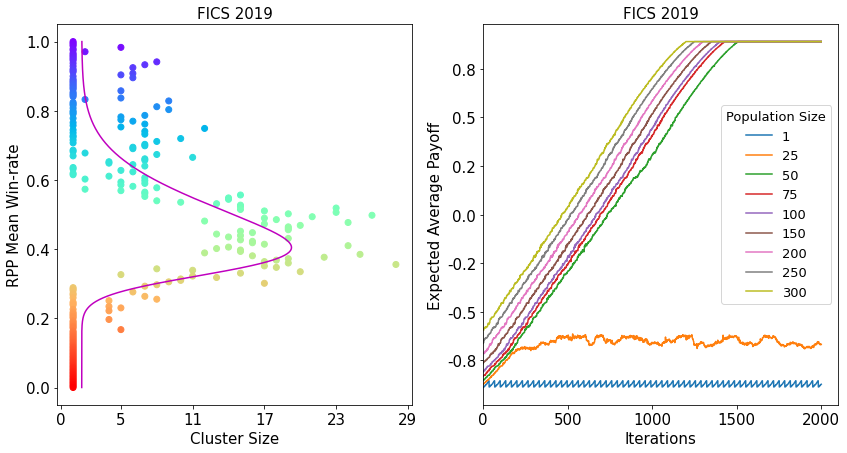

In [383]:
fig11, ax11 = plt.subplots(1, 2, figsize = (14, 7))
cmap = cm.get_cmap('rainbow')

for j in range(2):
    year = 2021

    if j % 2 == 0:
        # Plot Nash Clusters
        if year == 2021:
            path = 'Data/FICS/2019/'
            title = 'FICS 2019'
            data = openPickle(path + str(2019) + ' rpp sign tuples 1500 12')
            params = openPickle(path + str(2019) + ' NC Plot Params 1500 12')
        else:
            path = 'Data/' + str(year) + '/'
            title = 'Lichess ' + str(year)
            data = openPickle(path + str(year) + ' rpp sign tuples 1500 12')
            params = openPickle(path + str(year) + ' NC Plot Params 1500 12')

        _ = plot_nash_clusters_with_curve(data, title, 0, 1, init_params = params, cmap = cmap, ax = ax11[j])

    else:
        # Plot FP
        if year == 2021:
            path = 'FICS 2019 Training Nash'
            title = 'FICS 2019'
        else:
            path = 'Lichess ' + str(year) + ' Training Nash'
            title = 'Lichess ' + str(year)


        win_rates_results = openPickle(path)
        plot_training(win_rates_results, title, ax11[j], xlim = (0, None))

In [384]:
fig11.savefig('FP Training Nash FICS.pdf', dpi = 200, bbox_inches = 'tight')

## 12. Theoretical Game FP

In [217]:
def plot_training(win_rates_results, title, ax, xlim = None, ylim = None, fontsize = 15, legendsize = 13, ncol = 1):
    ax.set_title(title, fontsize = fontsize)
    for pop_size in win_rates_results.keys():
        win_rates = win_rates_results[pop_size]
        ax.plot(np.arange(len(win_rates)), win_rates, label = str(pop_size))
        
    ax.set_xlabel('Iterations', fontsize = fontsize)
    ax.set_ylabel('Expected Average Payoff', fontsize = fontsize)
    leg = ax.legend(title = 'Population Size', fontsize = legendsize, ncol = ncol)
    leg.set_title('Population Size', prop={'size': legendsize})
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    ax.tick_params(axis = 'x', labelsize = fontsize)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    
    if ylim is not None:
        ax.set_ylim(ylim)
        

def plot_nash_clusters(elo_data, title, xlim = None, ylim = None, ax = None, cmap = None, fontsize = 15):
    if ax == None:
        if cmap is None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], color = 'darkviolet')
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))
        plt.title(title)
        plt.ylabel('RPP Mean Win-rate')
        plt.xlabel('Cluster Size')
        
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], color = 'darkviolet')
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)-1, -1, -1))

        ax.set_title(title, fontsize = fontsize)
        ax.set_ylabel('RPP Mean Win-rate', fontsize = fontsize)
        ax.set_xlabel('Cluster Size', fontsize = fontsize)
        ax.tick_params(axis = 'x', labelsize = fontsize)
        ax.tick_params(axis = 'y', labelsize = fontsize)
        
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        
    return None

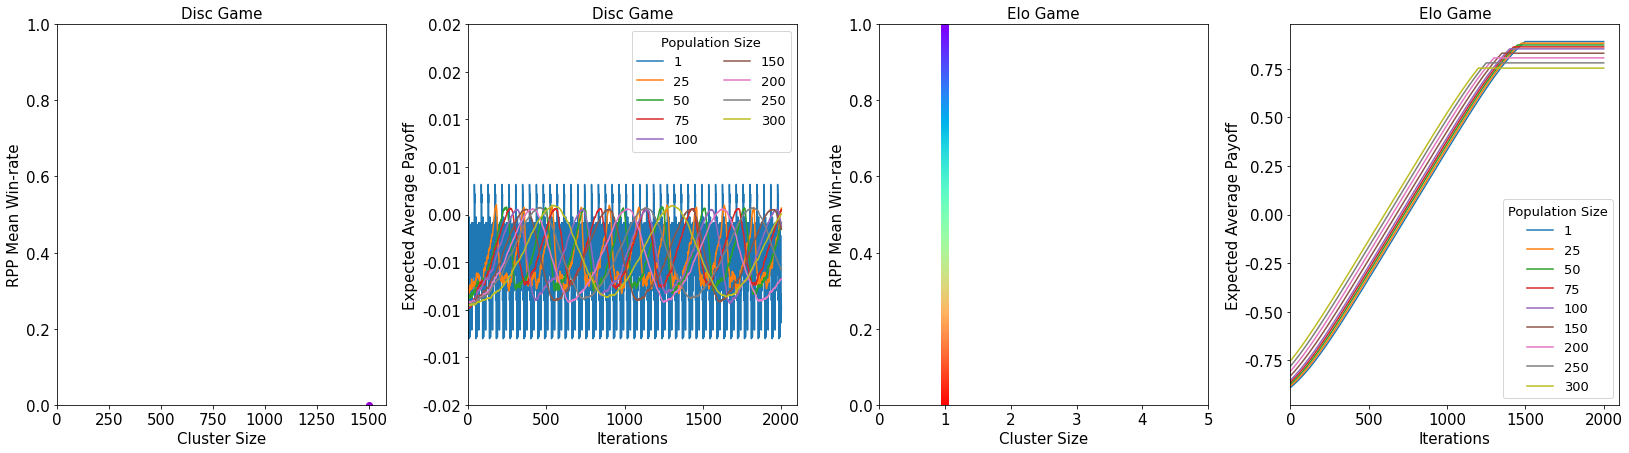

In [225]:
# Uniform (1 x 4)
fig12, ax12 = plt.subplots(1, 4, figsize = (28, 7))
cmap = cm.get_cmap('rainbow')
plt.subplots_adjust(wspace = 0.25)
jelo = [0, 1]
for i in range(1):
    for j in range(4):
        i = j % 2
        if i == 0:
            # Plot NC
            if j in jelo:
                # Disc Game
                nash_clusters = openPickle('Disc Game Nash Clusters 1500')
                plot_nash_clusters(np.array([[nash_clusters[0].size, 0]]), 'Disc Game', (0, None), (0, 1), ax12[j])

            else:
                # Elo Game
                nc_data = openPickle('Elo Game NC Data 1500')
                plot_nash_clusters(nc_data, 'Elo Game', xlim = (0, 5), ylim = (0, 1), ax = ax12[j], cmap = cmap)

        else:
            # Plot FP
            if j in jelo:
                # Disc Game
                win_rates_results = openPickle('Disc Game Training Uniform')
                plot_training(win_rates_results, 'Disc Game', ax12[j], xlim = (0, None), ylim = (-0.02, 0.02), ncol = 2)

            else:
                # Elo Game
                win_rates_results = openPickle('Elo Game Training Uniform')
                plot_training(win_rates_results, 'Elo Game', ax12[j], xlim = (0, None))
    
    

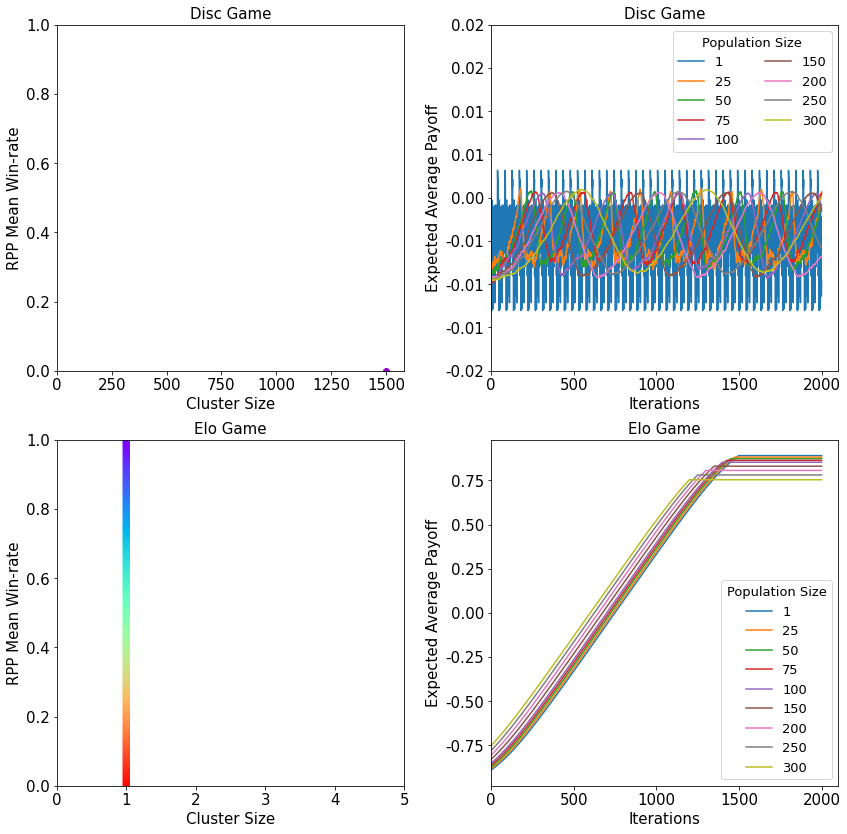

In [218]:
# Uniform (2 x 2)
fig12, ax12 = plt.subplots(2, 2, figsize = (14, 14))
cmap = cm.get_cmap('rainbow')
plt.subplots_adjust(wspace = 0.25)
j = 0
for i in range(2):
    for j in range(2):
        if i == 0:
            # Plot NC
            if j == 0:
                # Disc Game
                nash_clusters = openPickle('Disc Game Nash Clusters 1500')
                plot_nash_clusters(np.array([[nash_clusters[0].size, 0]]), 'Disc Game', (0, None), (0, 1), ax12[j][i])

            else:
                # Elo Game
                nc_data = openPickle('Elo Game NC Data 1500')
                plot_nash_clusters(nc_data, 'Elo Game', xlim = (0, 5), ylim = (0, 1), ax = ax12[j][i], cmap = cmap)

        else:
            # Plot FP
            if j == 0:
                # Disc Game
                win_rates_results = openPickle('Disc Game Training Uniform')
                plot_training(win_rates_results, 'Disc Game', ax12[j][i], xlim = (0, None), ylim = (-0.02, 0.02), ncol = 2)

            else:
                # Elo Game
                win_rates_results = openPickle('Elo Game Training Uniform')
                plot_training(win_rates_results, 'Elo Game', ax12[j][i], xlim = (0, None))
    
    

In [219]:
fig12.savefig('FP Training Uniform Theoretical.pdf', dpi = 200, bbox_inches = 'tight')

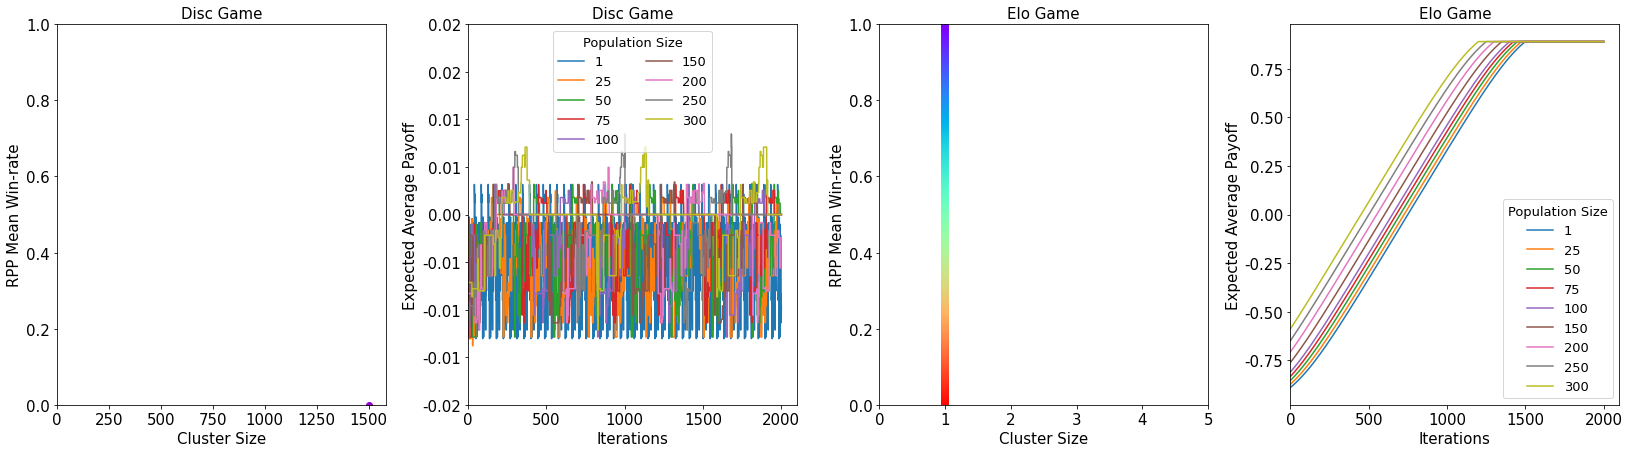

In [226]:
# Nash (1 x 4)
fig12, ax12 = plt.subplots(1, 4, figsize = (28, 7))
cmap = cm.get_cmap('rainbow')
plt.subplots_adjust(wspace = 0.25)
jelo = [0, 1]
for i in range(1):
    for j in range(4):
        i = j % 2
        if i == 0:
            # Plot NC
            if j in jelo:
                # Disc Game
                nash_clusters = openPickle('Disc Game Nash Clusters 1500')
                plot_nash_clusters(np.array([[nash_clusters[0].size, 0]]), 'Disc Game', (0, None), (0, 1), ax12[j])

            else:
                # Elo Game
                nc_data = openPickle('Elo Game NC Data 1500')
                plot_nash_clusters(nc_data, 'Elo Game', xlim = (0, 5), ylim = (0, 1), ax = ax12[j], cmap = cmap)

        else:
            # Plot FP
            if j in jelo:
                # Disc Game
                win_rates_results = openPickle('Disc Game Training Nash')
                plot_training(win_rates_results, 'Disc Game', ax12[j], xlim = (0, None), ylim = (-0.02, 0.02), ncol = 2)

            else:
                # Elo Game
                win_rates_results = openPickle('Elo Game Training Nash')
                plot_training(win_rates_results, 'Elo Game', ax12[j], xlim = (0, None))
    
    

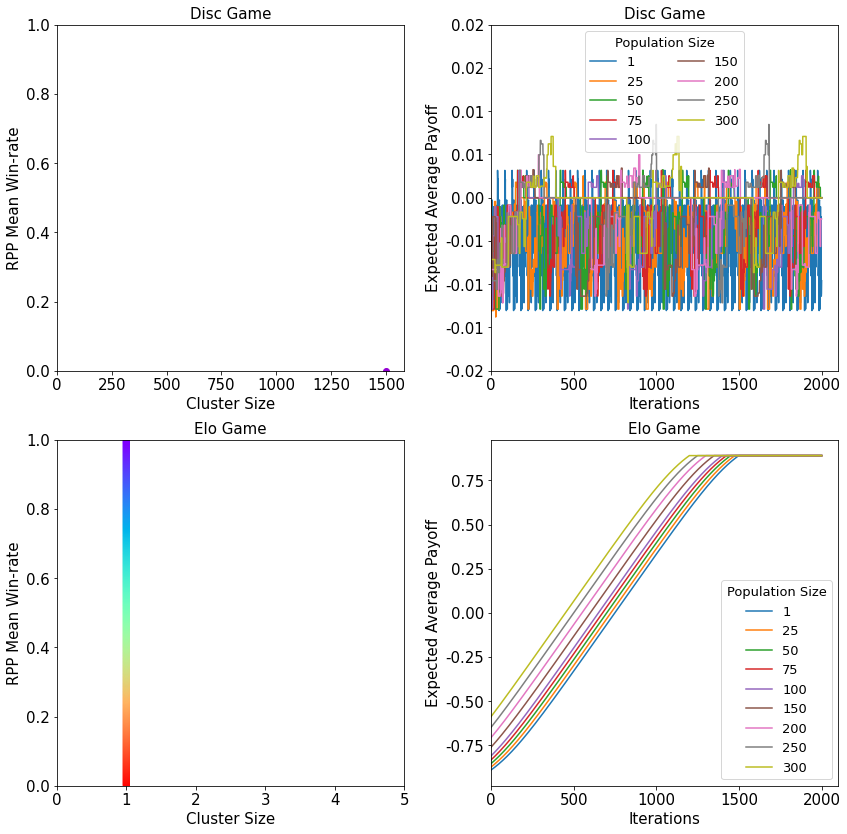

In [227]:
# Nash
fig12, ax12 = plt.subplots(2, 2, figsize = (14, 14))
cmap = cm.get_cmap('rainbow')
plt.subplots_adjust(wspace = 0.25)
j = 0
for i in range(2):
    for j in range(2):
        if i == 0:
            # Plot NC
            if j == 0:
                # Disc Game
                nash_clusters = openPickle('Disc Game Nash Clusters 1500')
                plot_nash_clusters(np.array([[nash_clusters[0].size, 0]]), 'Disc Game', (0, None), (0, 1), ax12[j][i])

            else:
                # Elo Game
                nc_data = openPickle('Elo Game NC Data 1500')
                plot_nash_clusters(nc_data, 'Elo Game', xlim = (0, 5), ylim = (0, 1), ax = ax12[j][i], cmap = cmap)

        else:
            # Plot FP
            if j == 0:
                # Disc Game
                win_rates_results = openPickle('Disc Game Training Nash')
                plot_training(win_rates_results, 'Disc Game', ax12[j][i], xlim = (0, None), ylim = (-0.02, 0.02), ncol = 2)

            else:
                # Elo Game
                win_rates_results = openPickle('Elo Game Training Nash')
                plot_training(win_rates_results, 'Elo Game', ax12[j][i], xlim = (0, None))
    
    

In [228]:
fig12.savefig('FP Training Nash Theoretical.pdf', dpi = 200, bbox_inches = 'tight')

## 13. Rating Conversions

In [322]:
parameters_LR = openPickle('LR Parameters')
parameters_CR = openPickle('CR Parameters')
parameters_PR = openPickle('PR Parameters')
data_all = openPickle('Rating Data Pairs')

In [323]:
keys = ['Lichess-USCF', 'Lichess-FIDE', 'USCF-FIDE']
x_bounds = dict()
# x_bounds[keys[0]] = [920, 2750]
# x_bounds[keys[1]] = [1600, 2750]
# x_bounds[keys[2]] = [1200, 2600]

x_bounds[keys[0]] = [750, 2950]
x_bounds[keys[1]] = [750, 2950]
x_bounds[keys[2]] = [750, 2950]


axlabel = dict()
axlabel[keys[0]] = ['Lichess Rating(x)', 'USCF Rating (y)']
axlabel[keys[1]] = ['Lichess Rating(x)', 'FIDE Rating (y)']
axlabel[keys[2]] = ['USCF Rating(x)', 'FIDE Rating (y)']

titles = dict()
titles[keys[0]] = 'Lichess to USCF'
titles[keys[1]] = 'Lichess to FIDE'
titles[keys[2]] = 'USCF to FIDE'

In [130]:
a = 0.5059188 * 1e-6
a_text = '{:.3}'.format(a)


$3x^2$


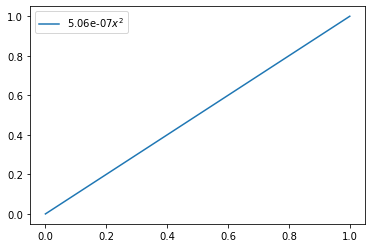

In [133]:
power_text = int(2)
legend_text = a_text + '$x^{power_text}$'.format(power_text = power_text)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label = legend_text)
plt.legend()

In [348]:
def plot_regression(parameters, x, y, x_bounds, ax, xlabel, ylabel, title,
                    xlim = None, ylim = None, cmap = None, set_xtick = False, fontsize = 15, legendsize = 12):
    
    N = len(parameters)
    param_text = ['{:.3}'.format(abs(param)) for param in parameters]
    
    
    power = N - 1; idx = 0
    sign = '-' if parameters[0] < 0 else ''
    legend_text = 'y={sign}'.format(sign = sign)
    while power >=0:
        power_text = str(int(power))
        
        if power > 0:
            if parameters[idx + 1] > 0:
                sign = '+'
            else:
                sign = '-'
            
        if power > 1:
            legend_text = legend_text + param_text[idx] + '$x^{power_text}{sign}$'.format(power_text = power_text, sign = sign)
        elif power == 1:
            legend_text = legend_text + param_text[idx] + '$x{sign}$'.format(power_text = power_text, sign = sign)
        else:
            legend_text = legend_text + param_text[idx]
            
        power -= 1
        idx += 1
        
    
    x_plot = np.linspace(x_bounds[0], x_bounds[1], 200)
    x_transform = np.vander(x_plot, N)
    y_plot = (x_transform @ parameters.reshape(-1, 1)).reshape(-1)
    
    if cmap is not None:
        ax.scatter(x, y, cmap = cmap, c = np.arange(len(x)))
        
    else:
        ax.scatter(x, y, c = 'b')
        
    ax.plot(x_plot, y_plot, c = 'r', label = legend_text)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
        
    leg = ax.legend(loc = 'upper left', fontsize = legendsize, borderpad = 0, handlelength = 0.0)
    
    if set_xtick:
        ax.set_xticks(np.linspace(x_bounds[0], x_bounds[1], 5))
    
    ax.set_xlabel(xlabel, fontsize = fontsize)
    ax.set_ylabel(ylabel, fontsize = fontsize)
    ax.grid()
    ax.set_title(title, fontsize = fontsize)
    ax.tick_params(axis = 'x', labelsize = fontsize)
    ax.tick_params(axis = 'y', labelsize = fontsize)
        
    

In [225]:
np.linspace(750, 2950, 5).astype('int64')

array([ 750, 1300, 1850, 2400, 2950], dtype=int64)

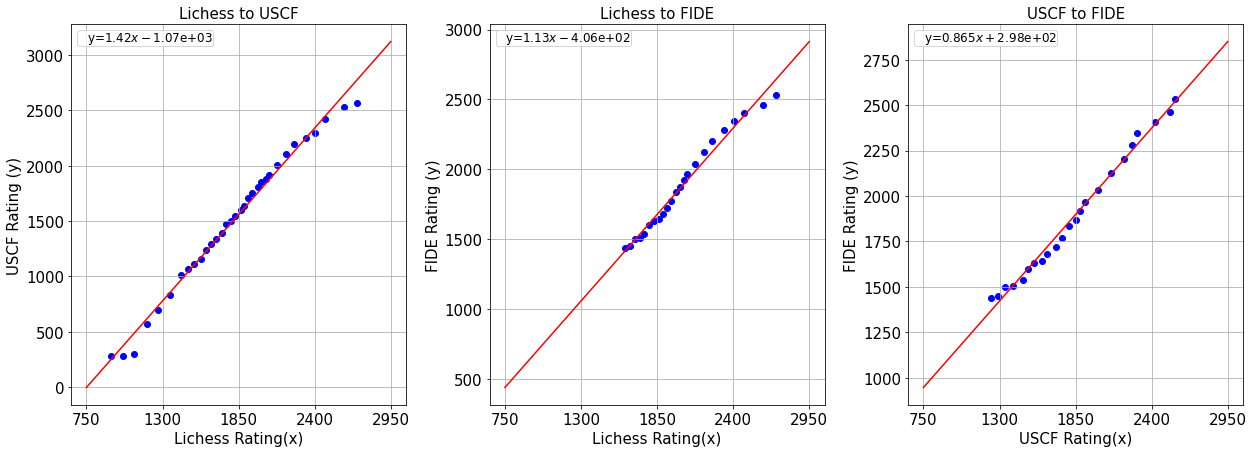

In [353]:
fig13, ax13 = plt.subplots(1, 3, figsize = (21, 7))
cmap = cm.get_cmap('rainbow')
plt.subplots_adjust(wspace = 0.25)

for i in range(3):
    key = keys[i]
    
    parameter = parameters_LR[key]; x,y = data_all[key]; x_bound = x_bounds[key]; xlabel, ylabel = axlabel[key]
    title = titles[key]
    plot_regression(parameter, x, y, x_bound, ax13[i], xlabel, ylabel, title, set_xtick = True)

In [354]:
fig13.savefig('LR Rating.pdf', dpi = 200, bbox_inches = 'tight')

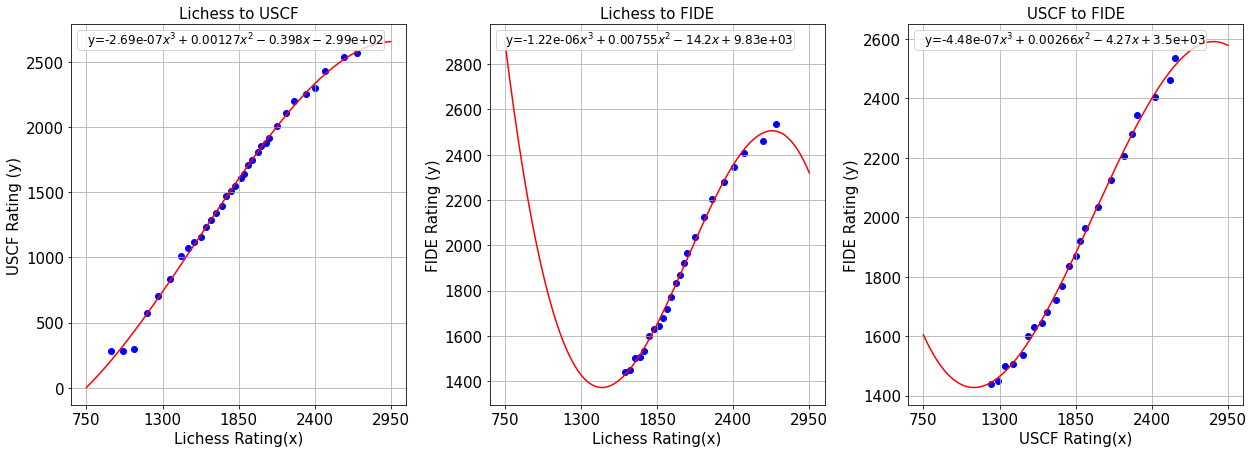

In [355]:
fig13, ax13 = plt.subplots(1, 3, figsize = (21, 7))
cmap = cm.get_cmap('rainbow')
plt.subplots_adjust(wspace = 0.25)
for i in range(3):
    key = keys[i]
    
    parameter = parameters_CR[key]; x,y = data_all[key]; x_bound = x_bounds[key]; xlabel, ylabel = axlabel[key]
    title = titles[key]
    plot_regression(parameter, x, y, x_bound, ax13[i], xlabel, ylabel, title, set_xtick = True)

In [356]:
fig13.savefig('CR Rating.pdf', dpi = 200, bbox_inches = 'tight')

In [203]:
parameters_LR[keys[1]]

array([   1.12529246, -405.82068935])

### 15. Histogram vs Nash Clusters

In [297]:
def affine_skewed_normal_loss(parameters, xdata, ydata):
    """
    parameters shape is [\mu, \sigma, \alpha, \a, \b]
    """
    mu, sigma, alpha, a, b = parameters
    
    # Compute the loss
    out = a * (sigma ** 2) * skewnorm.pdf(xdata, alpha, mu, sigma**2) + b
#     out = a * skewnorm.pdf(xdata, alpha, mu, sigma) + b
    loss = np.sum((out - ydata) ** 2)
    
    return loss

def affine_skewed_normal_pdf(parameters, xdata):
    mu, sigma, alpha, a, b = parameters
    out = a * (sigma ** 2) * skewnorm.pdf(xdata, alpha, mu, sigma**2) + b
#     out = a * skewnorm.pdf(xdata, alpha, mu, sigma) + b
    return out

def fit_skewed_normal(init, xdata, ydata):
    bnds = [(None, None), (1e-15, None), (None, None), (None, None), (None, None)]
    results = minimize(affine_skewed_normal_loss, init, args = (xdata, ydata), bounds = bnds, tol = 1e-8)
    return results.x

def fit_hist_count(counts, points, seed = 888, init_param = None):
    
    np.random.seed(seed)
    
    if init_param is not None:
        init = init_param
    
    else:
        init = np.random.uniform(0, 1, size = (5))
        
    init[0] = 1500; init[1] = 20 * np.sqrt(2)
    
#     init[2] = -1; init[3] = 1e5; init[4] = -2e3
    
    x_data = points; y_data = counts
    params = fit_skewed_normal(init, x_data, y_data)
    
    return params

def plot_nash_clusters_with_curve_elo_2(elo_data, title, lb, ub, seed = 88, ax = None, init_params = None, cmap = None):
    if ax == None:
        if cmap == None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))
        plt.title(title)
        plt.ylabel('Average Elo Rating')
        plt.xlabel('Cluster Size')
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))

        ax.set_title(title)
        ax.set_ylabel('Average Elo Rating')
        ax.set_xlabel('Cluster Size')
    
    np.random.seed(seed)
    y_data = elo_data[:, 0]; x_data = elo_data[:, 1]
    init = np.random.uniform(0, 100, size = (5))
    
#     if init_params is not None:
#         init[0] = init_params[0]
#         init[1] = init_params[1]
    
#     params = fit_skewed_normal(init, x_data, y_data)

    if init_params is not None:
        params = init_params
    else:
        params = fit_skewed_normal(init_params, x_data, y_data)

    inputs = np.linspace(lb, ub, 1000)
    outputs = affine_skewed_normal_pdf(params, inputs)
    
    outputs[outputs < 1] = 1
    
    if ax == None:
        plt.plot(outputs, inputs, color = 'm')
    else:
        ax.plot(outputs, inputs, color = 'm')
    
    return params

In [303]:
hist_count_parameters = dict()


In [328]:
hist_count_parameters[2021] = hist_count_params

In [329]:
savePickle(hist_count_parameters, 'Histogram Param Counts All')

In [326]:
points, counts = openPickle('Data/FICS/2019/Histogram Count Data')
bins = create_bins(750, 2950, 100)
bins = np.array(bins)
hist_bins = np.concatenate([bins[:, 0], [2950]])
total_counts = np.sum(counts)
hist_param = openPickle('Data/FICS/2019/Histogram Param')
print(hist_param)

[1.50002681e+03 1.62487899e+01 4.74554666e-01 8.23504182e-02
 1.20163464e-04]


[1.49698262e+03 1.62622122e+01 4.90998841e-01 2.36979385e+05
 3.45789182e+02]


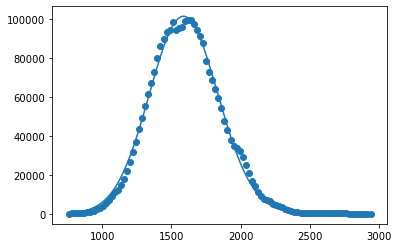

In [327]:
init = hist_param
init[3] = init[3] * total_counts
init[4] = init[4] * total_counts
hist_count_params = fit_hist_count(counts, points, init_param = init)
inputs = np.linspace(750, 2950, 200)
outputs = affine_skewed_normal_pdf(hist_count_params, inputs)
plt.scatter(points, counts)
plt.plot(inputs, outputs)
# plt.hist(points, weights = counts, bins = hist_bins )

print(hist_count_params)

In [330]:
nc_elo_data = openPickle("Nash Cluster Plot Data Elo")
elo_param_dict = openPickle("Nash Cluster Plot Param Elo")
hist_params_count = openPickle("Histogram Param Counts All")

In [385]:
def plot_nash_clusters_with_curve_elo_2(elo_data, title, lb, ub, seed = 88, ax = None, init_params = None, cmap = None):
    if ax == None:
        if cmap == None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))
        plt.title(title)
        plt.ylabel('Average Elo Rating')
        plt.xlabel('Cluster Size')
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))

        ax.set_title(title, fontsize = 15)
        ax.set_ylabel('Average Elo Rating', fontsize = 15)
        ax.set_xlabel('Cluster Size', fontsize = 15)
        
        ax.tick_params(axis = 'x', labelsize = 15)
        ax.tick_params(axis = 'y', labelsize = 15)
        
        xlim = ax.get_xlim()
        ax.set_xticks(np.linspace(0, xlim[1], 6).astype('int64'))
    
    np.random.seed(seed)
    y_data = elo_data[:, 0]; x_data = elo_data[:, 1]
    init = np.random.uniform(0, 100, size = (5))
    
#     if init_params is not None:
#         init[0] = init_params[0]
#         init[1] = init_params[1]
    
#     params = fit_skewed_normal(init, x_data, y_data)

    if init_params is not None:
        params = init_params
    else:
        params = fit_skewed_normal(init_params, x_data, y_data)

    inputs = np.linspace(lb, ub, 1000)
    outputs = affine_skewed_normal_pdf(params, inputs)
    
    outputs[outputs < 1] = 1
    
    if ax == None:
        plt.plot(outputs, inputs, color = 'm')
    else:
        ax.plot(outputs, inputs, color = 'm')
    
    return params

In [86]:
np.linspace(0, 1, 6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

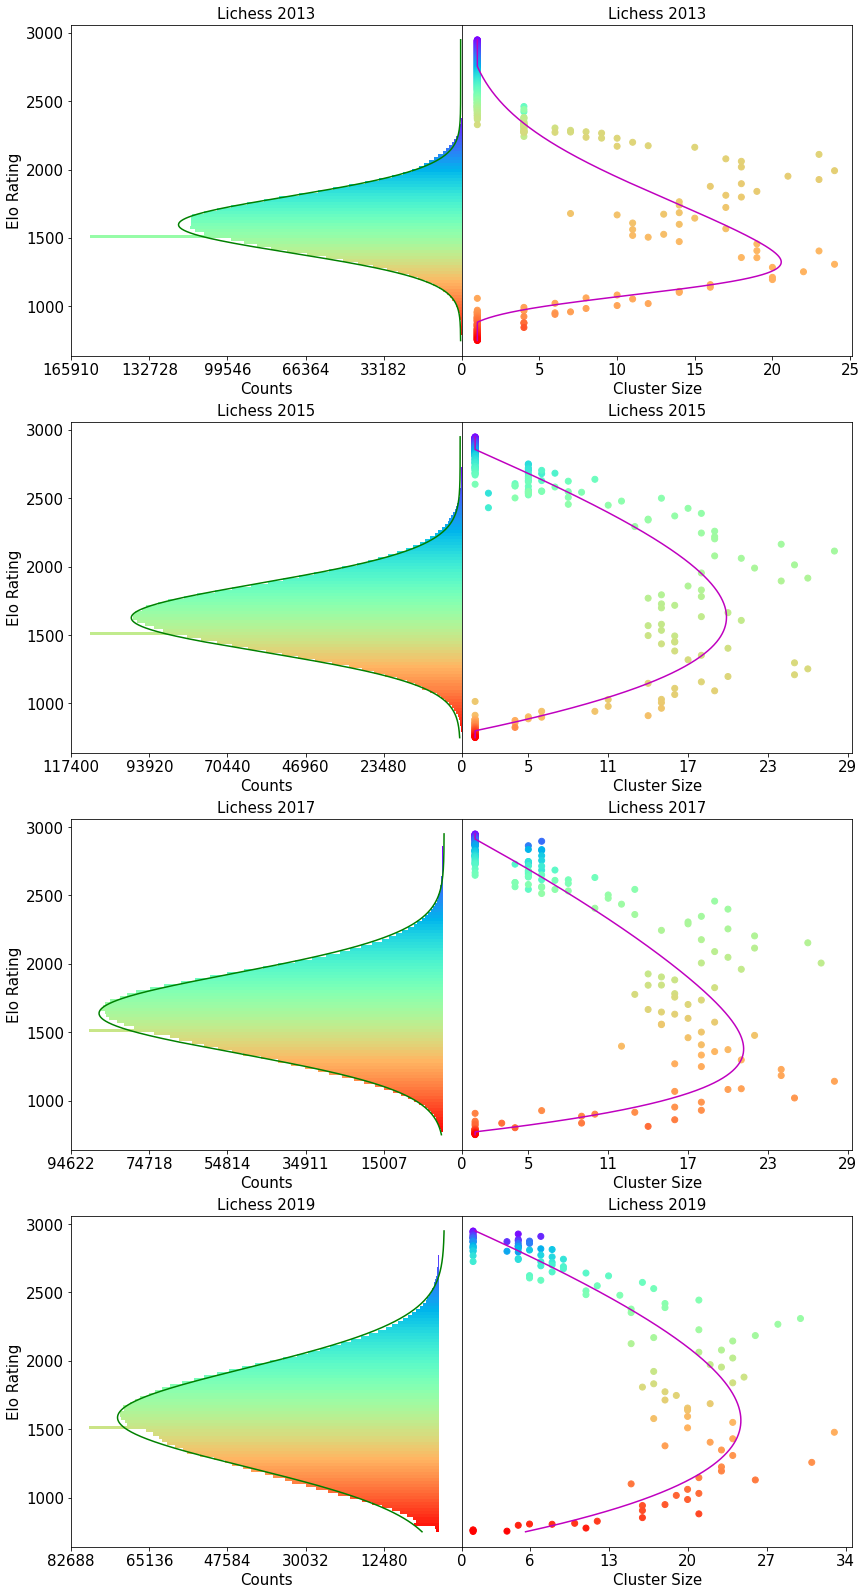

In [386]:
# Histogram and spinning top in one plot
lb = 750; ub = 2950; n = 1500
bins = create_bins(lb ,ub , n)
cmap = cm.get_cmap('rainbow')

fig15, ax15 = plt.subplots(4, 2, figsize = (14, 28))
plt.subplots_adjust(wspace = 0)
years = [2013, 2015, 2017, 2019]
for i in range(4):
    year = years[i]
    title = 'Lichess ' + str(year)
    
    # Histogram
    path = 'Data/' + str(year) + '/Histogram Count Data'
    path_param = 'Data/' + str(year) + '/Histogram Param'
    
    points, counts = openPickle(path)
    total_counts = np.sum(counts)
    
    inputs = np.linspace(750, 2950, 1000)
    
    # Version 1: Take Density Params, compute output, then scale by total counts
    hist_param = openPickle(path_param)
    hist_outputs = total_counts * affine_skewed_normal_pdf(hist_param, inputs)
    
#     # Version 2: Take Density Params, scale by total counts, use as starting condition. Fitted earlier
#     hist_param = hist_params_count[year]
#     hist_outputs = affine_skewed_normal_pdf(hist_param, inputs)
    
    out_count, bins, patches = ax15[i][0].hist(points, orientation = 'horizontal', bins = hist_bins, weights = counts, color = 'orange')
    out_count = out_count / np.sum(out_count)
    ax15[i][0].plot(hist_outputs, inputs, color = 'g')
    ax15[i][0].set_title(title, fontsize = 15)
    ax15[i][0].set_ylabel('Elo Rating', fontsize = 15)
    ax15[i][0].set_xlabel('Counts', fontsize = 15)
    ax15[i][0].tick_params(axis = 'x', labelsize = 15)
    ax15[i][0].tick_params(axis = 'y', labelsize = 15)
    xlim = ax15[i][0].get_xlim()
    ax15[i][0].set_xticks(np.linspace(xlim[0], xlim[1], 6))
    
    
    # Set Color
    thresh = 1e-5
    aranger = np.arange(np.sum(out_count >= thresh))
    aranger = aranger / len(aranger)
    counter = len(aranger) - 1
    for idx, patch in enumerate(patches):
        if out_count[idx] >= thresh:
            value = aranger[counter]
            plt.setp(patch, 'facecolor', cmap(value))
            counter -= 1
            
    # Flip the plot
    ticks = ax15[i][0].get_xticks()
    ax15[i][0].set_xticks(ticks[ticks > 0])
    
    xlim = ax15[i][0].get_xlim()
    ax15[i][0].set_xlim(xlim[1], xlim[0])
    
    # Elo
    elo_data = nc_elo_data[year]
    param = elo_param_dict[year]
    _ = plot_nash_clusters_with_curve_elo_2(elo_data, title, 750, 2950, cmap = cmap, 
                                            init_params = param, ax = ax15[i][1])
        
    # Adjust the labellings
    ax15[i][1].set_ylabel('')
    ax15[i][1].set_yticks([])
    ax15[i][1].tick_params(labelleft = False)
    ax15[i][1].set_xlim(0)
    

In [387]:
fig15.savefig('Histogram and Nash Cluster Left Column.pdf', dpi = 200, bbox_inches = 'tight')

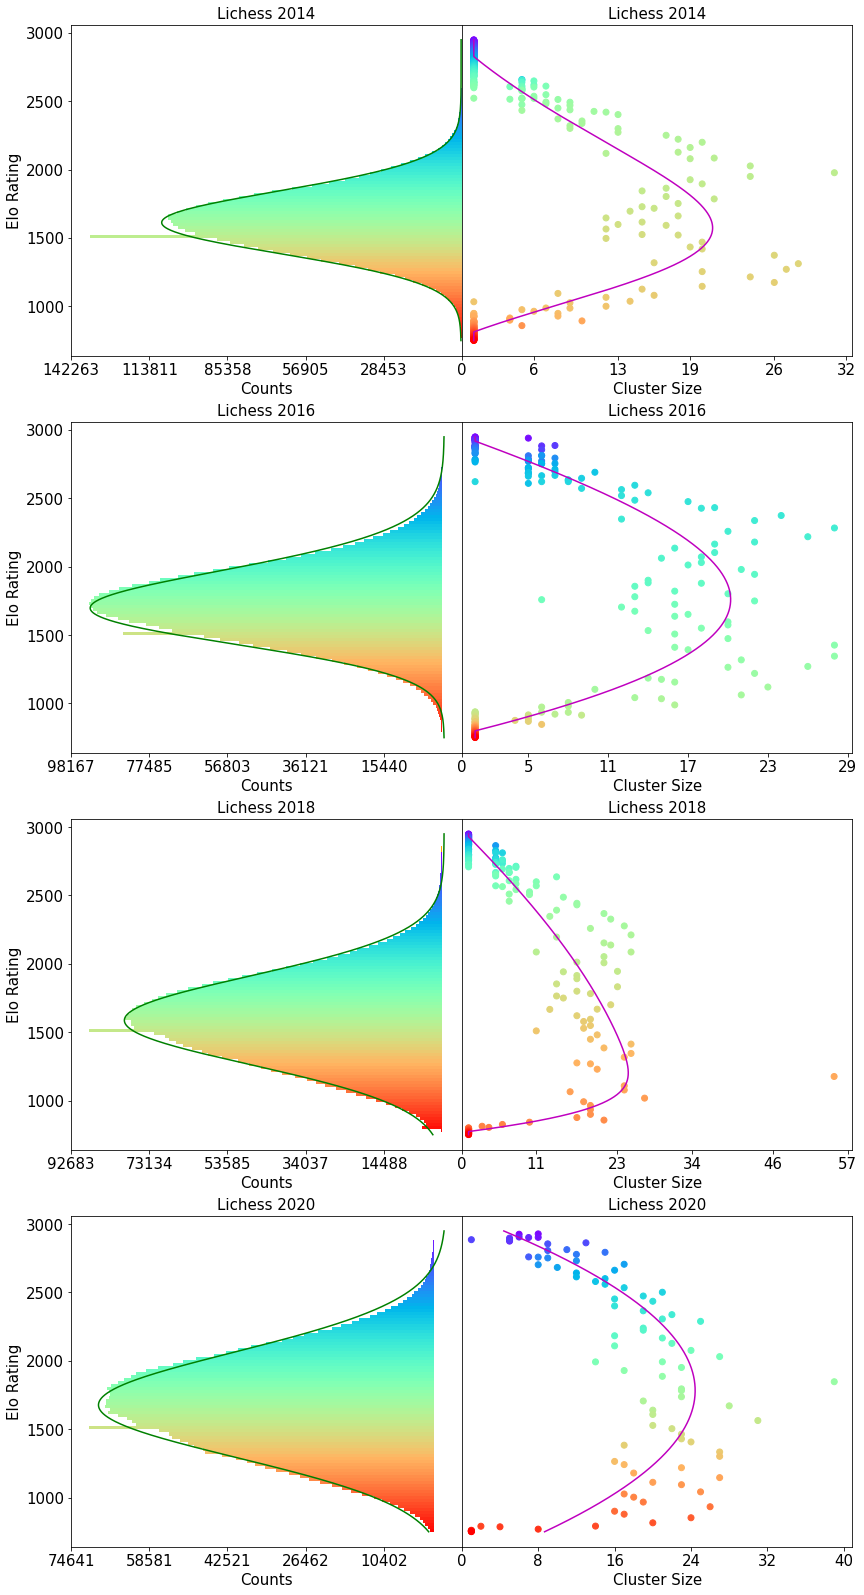

In [388]:
# Histogram and spinning top in one plot
lb = 750; ub = 2950; n = 1500
bins = create_bins(lb ,ub , n)
cmap = cm.get_cmap('rainbow')

fig15, ax15 = plt.subplots(4, 2, figsize = (14, 28))
plt.subplots_adjust(wspace = 0)
years = [2014, 2016, 2018, 2020]
for i in range(4):
    year = years[i]
    title = 'Lichess ' + str(year)
    
    # Histogram
    path = 'Data/' + str(year) + '/Histogram Count Data'
    path_param = 'Data/' + str(year) + '/Histogram Param'
    
    points, counts = openPickle(path)
    total_counts = np.sum(counts)
    
    inputs = np.linspace(750, 2950, 1000)
    
    # Version 1: Take Density Params, compute output, then scale by total counts
    hist_param = openPickle(path_param)
    hist_outputs = total_counts * affine_skewed_normal_pdf(hist_param, inputs)
    
#     # Version 2: Take Density Params, scale by total counts, use as starting condition. Fitted earlier
#     hist_param = hist_params_count[year]
#     hist_outputs = affine_skewed_normal_pdf(hist_param, inputs)
    
    out_count, bins, patches = ax15[i][0].hist(points, orientation = 'horizontal', bins = hist_bins, weights = counts, color = 'orange')
    out_count = out_count / np.sum(out_count)
    ax15[i][0].plot(hist_outputs, inputs, color = 'g')
    ax15[i][0].set_title(title, fontsize = 15)
    ax15[i][0].set_ylabel('Elo Rating', fontsize = 15)
    ax15[i][0].set_xlabel('Counts', fontsize = 15)
    ax15[i][0].tick_params(axis = 'x', labelsize = 15)
    ax15[i][0].tick_params(axis = 'y', labelsize = 15)
    xlim = ax15[i][0].get_xlim()
    ax15[i][0].set_xticks(np.linspace(xlim[0], xlim[1], 6))
    
    # Set Color
    thresh = 1e-5
    aranger = np.arange(np.sum(out_count >= thresh))
    aranger = aranger / len(aranger)
    counter = len(aranger) - 1
    for idx, patch in enumerate(patches):
        if out_count[idx] >= thresh:
            value = aranger[counter]
            plt.setp(patch, 'facecolor', cmap(value))
            counter -= 1
            
    # Flip the plot
    ticks = ax15[i][0].get_xticks()
    ax15[i][0].set_xticks(ticks[ticks > 0])
    
    xlim = ax15[i][0].get_xlim()
    ax15[i][0].set_xlim(xlim[1], xlim[0])
    
    # Elo
    elo_data = nc_elo_data[year]
    param = elo_param_dict[year]
    _ = plot_nash_clusters_with_curve_elo_2(elo_data, title, 750, 2950, cmap = cmap, 
                                            init_params = param, ax = ax15[i][1])
        
    # Adjust the labellings
    ax15[i][1].set_ylabel('')
    ax15[i][1].set_yticks([])
    ax15[i][1].tick_params(labelleft = False)
    ax15[i][1].set_xlim(0)
    
    

In [389]:
fig15.savefig('Histogram and Nash Cluster Right Column.pdf', dpi = 200, bbox_inches = 'tight')

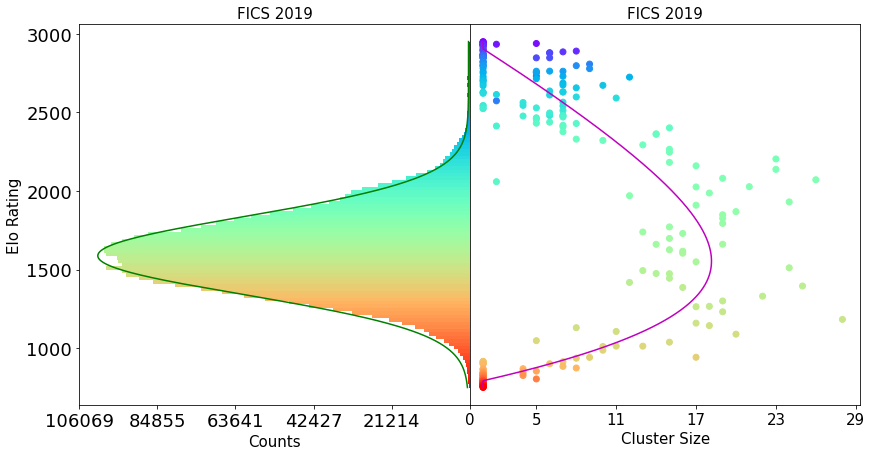

In [390]:
# Histogram and spinning top in one plot
lb = 750; ub = 2950; n = 1500
bins = create_bins(lb ,ub , n)
cmap = cm.get_cmap('rainbow')

fig15, ax15 = plt.subplots(1, 2, figsize = (14, 7))
plt.subplots_adjust(wspace = 0)
for i in range(1):
    year = 2021
    title = 'FICS 2019'
    
    # Histogram
    path = 'Data/FICS/2019/Histogram Count Data'
    path_param = 'Data/FICS/2019/Histogram Param'
    
    points, counts = openPickle(path)
    total_counts = np.sum(counts)
    
    inputs = np.linspace(750, 2950, 1000)
    
    # Version 1: Take Density Params, compute output, then scale by total counts
    hist_param = openPickle(path_param)
    hist_outputs = total_counts * affine_skewed_normal_pdf(hist_param, inputs)
    
#     # Version 2: Take Density Params, scale by total counts, use as starting condition. Fitted earlier
#     hist_param = hist_params_count[year]
#     hist_outputs = affine_skewed_normal_pdf(hist_param, inputs)
    
    out_count, bins, patches = ax15[0].hist(points, orientation = 'horizontal', bins = hist_bins, weights = counts, color = 'orange')
    out_count = out_count / np.sum(out_count)
    ax15[0].plot(hist_outputs, inputs, color = 'g')
    ax15[0].set_title(title, fontsize = 15)
    ax15[0].set_ylabel('Elo Rating', fontsize = 15)
    ax15[0].set_xlabel('Counts', fontsize = 15)
    xlim = ax15[0].get_xlim()
    ax15[0].set_xticks(np.linspace(xlim[0], xlim[1], 6))
    ax15[0].tick_params(axis = 'x', labelsize = 18)
    ax15[0].tick_params(axis = 'y', labelsize = 18)
    
    # Set Color
    thresh = 1e-5
    aranger = np.arange(np.sum(out_count >= thresh))
    aranger = aranger / len(aranger)
    counter = len(aranger) - 1
    for idx, patch in enumerate(patches):
        if out_count[idx] >= thresh:
            value = aranger[counter]
            plt.setp(patch, 'facecolor', cmap(value))
            counter -= 1
            
    # Flip the plot
    ticks = ax15[0].get_xticks()
    ax15[0].set_xticks(ticks[ticks > 0])
    
    xlim = ax15[0].get_xlim()
    ax15[0].set_xlim(xlim[1], xlim[0])
    
    # Elo
    elo_data = nc_elo_data[year]
    param = elo_param_dict[year]
    _ = plot_nash_clusters_with_curve_elo_2(elo_data, title, 750, 2950, cmap = cmap, 
                                            init_params = param, ax = ax15[1])
        
    # Adjust the labellings
    ax15[1].set_ylabel('')
    ax15[1].set_yticks([])
    ax15[1].tick_params(labelleft = False)
    ax15[1].set_xlim(0)
    
    

In [391]:
fig15.savefig('Histogram and Nash Cluster FICS.pdf', dpi = 200, bbox_inches = 'tight')

### Appendixes

In [394]:
filename = 'spinning_top_payoffs.pkl'
with open(filename, 'rb') as f:
    payoffs = pickle.load(f)

In [408]:
def plot_training(win_rates_results, title, ax, xlim = None, ylim = None, fontsize = 15, legendsize = 13, ncol = 1):
    ax.set_title(title, fontsize = fontsize)
    for pop_size in win_rates_results.keys():
        win_rates = win_rates_results[pop_size]
        ax.plot(np.arange(len(win_rates)), win_rates, label = str(pop_size))
        
    ax.set_xlabel('Iterations', fontsize = fontsize)
    ax.set_ylabel('Expected Average Payoff', fontsize = fontsize)
    leg = ax.legend(title = 'Population Size', fontsize = legendsize, ncol = ncol)
    leg.set_title('Population Size', prop={'size': legendsize})
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    ax.tick_params(axis = 'x', labelsize = fontsize)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    
    if ylim is not None:
        ax.set_ylim(ylim)
        
def plot_nash_clusters_with_curve(elo_data, title, lb, ub, seed = 88, ax = None, init_params = None, 
                                  fontsize = 15, cmap = None):
    if ax == None:
        if cmap == None:
            plt.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            plt.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))
        plt.title(title)
        plt.ylabel('RPP Mean Win-rate')
        plt.xlabel('Cluster Size')
        
    else:
        if cmap == None:
            ax.scatter(elo_data[:, 0], elo_data[:, 1])
        else:
            ax.scatter(elo_data[:, 0], elo_data[:, 1], cmap = cmap, c = np.arange(len(elo_data)))

        ax.set_title(title, fontsize = fontsize)
        ax.set_ylabel('RPP Mean Win-rate', fontsize = fontsize)
        ax.set_xlabel('Cluster Size', fontsize = fontsize)
        ax.tick_params(axis = 'x', labelsize = fontsize)
        ax.tick_params(axis = 'y', labelsize = fontsize)
        
        xlim = ax.get_xlim()
        ax.set_xticks(np.linspace(0, xlim[1], 6).astype('int64'))
    
    np.random.seed(seed)
    y_data = elo_data[:, 0]; x_data = elo_data[:, 1]
    init = np.random.uniform(0, 100, size = (5))
    
    
    if init_params is not None:
        params = init_params
    else:
        params = fit_skewed_normal(init, x_data, y_data)

    inputs = np.linspace(lb, ub, 1000)
    outputs = affine_skewed_normal_pdf(params, inputs)
    
    if ax == None:
        plt.plot(outputs, inputs, color = 'm')
    else:
        ax.plot(outputs, inputs, color = 'm')
    
    return params

def generate_RPP_data(nash_clusters, payoff):
    data_tuples_rpp = []; n_nc = len(nash_clusters); data_tuples_rpp_sign = []; rpp_mat = np.zeros((n_nc, n_nc))
    for i, nc_i in enumerate(nash_clusters):
        rpp_sum = 0; rpp_sign_sum = 0
        for j, nc_j in enumerate(nash_clusters):
            if i != j:
                rpp = compute_RPP(nc_i, nc_j, payoff)
                rpp_mat[i,j] = rpp
                rpp_sum += rpp
                rpp_sign_sum += 1 * (rpp >= 0)

        rpp_sum = rpp_sum / n_nc; rpp_sign_sum = rpp_sign_sum / (n_nc - 1)

        data_tuples_rpp.append([nc_i.size, rpp_sum])
        data_tuples_rpp_sign.append([nc_i.size, rpp_sign_sum])

    return np.array(data_tuples_rpp), np.array(data_tuples_rpp_sign), rpp_mat

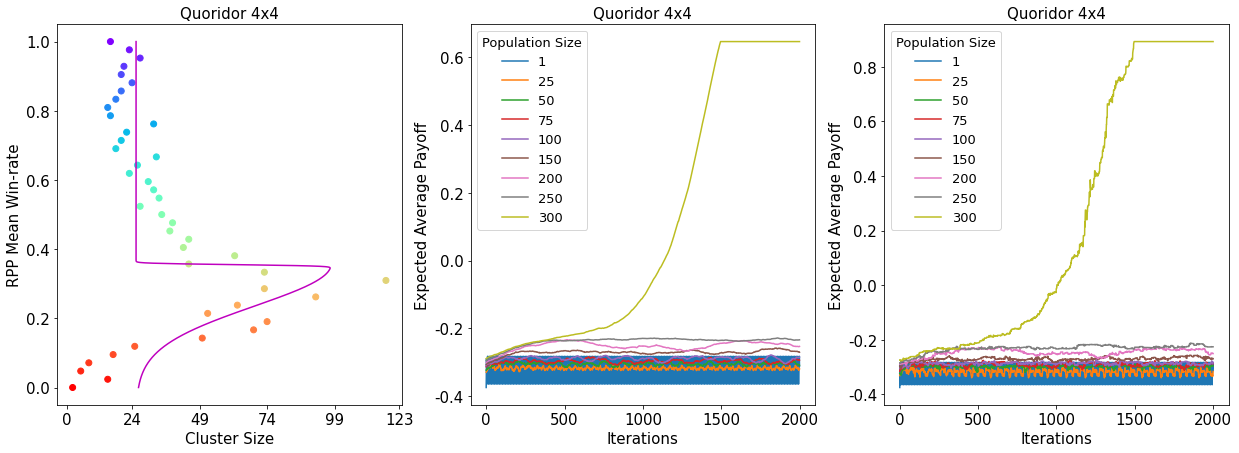

In [409]:
### Quoridor 4
title = "Quoridor 4x4"
nash_clusters = openPickle(title + " Nash Clusters")
uniform_training = openPickle(title + " Uniform Training")
nash_training = openPickle(title + " Nash Training")
nash_params = openPickle(title + " NC Params")
payoff = payoffs['quoridor(board_size=4)']
cmap = cm.get_cmap('rainbow')

fig16, ax16 = plt.subplots(1, 3, figsize = (21, 7))

for i in range(3):
    if i == 0:
        # Plot Nash Clusters
        _, nc_data, _ = generate_RPP_data(nash_clusters, payoff)
        plot_nash_clusters_with_curve(nc_data, title, 0, 1, ax = ax16[i], init_params = nash_params, cmap = cmap)
        
    elif i == 1:
        # Training uniform
        plot_training(uniform_training, title, ax = ax16[i])
        
    else:
        # Training Nash
        plot_training(nash_training, title, ax = ax16[i])

In [410]:
fig16.savefig(title + " appendix.pdf", dpi = 200, bbox_inches = 'tight')

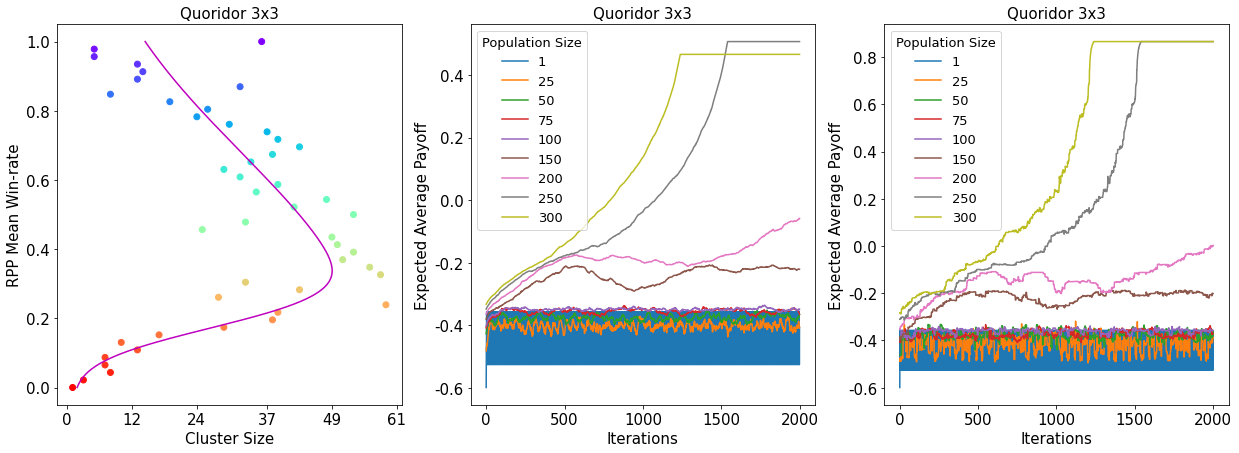

In [412]:
### Quoridor 3
title = "Quoridor 3x3"
nash_clusters = openPickle(title + " Nash Clusters")
uniform_training = openPickle(title + " Uniform Training")
nash_training = openPickle(title + " Nash Training")
nash_params = openPickle(title + " NC Params")
payoff = payoffs['quoridor(board_size=3)']
cmap = cm.get_cmap('rainbow')

fig16, ax16 = plt.subplots(1, 3, figsize = (21, 7))

for i in range(3):
    if i == 0:
        # Plot Nash Clusters
        _, nc_data, _ = generate_RPP_data(nash_clusters, payoff)
        plot_nash_clusters_with_curve(nc_data, title, 0, 1, ax = ax16[i], init_params = nash_params, cmap = cmap)
        
    elif i == 1:
        # Training uniform
        plot_training(uniform_training, title, ax = ax16[i])
        
    else:
        # Training Nash
        plot_training(nash_training, title, ax = ax16[i])

In [413]:
fig16.savefig(title + " appendix.pdf", dpi = 200, bbox_inches = 'tight')

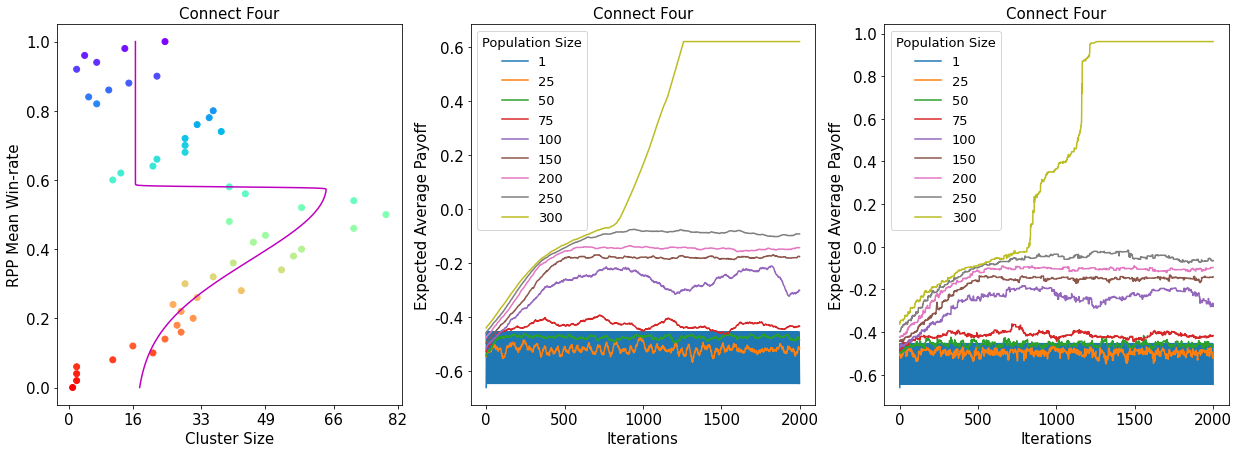

In [414]:
### Connect Four
title = "Connect Four"
nash_clusters = openPickle(title + " Nash Clusters")
uniform_training = openPickle(title + " Uniform Training")
nash_training = openPickle(title + " Nash Training")
nash_params = openPickle(title + " NC Params")
payoff = payoffs['connect_four']
cmap = cm.get_cmap('rainbow')

fig16, ax16 = plt.subplots(1, 3, figsize = (21, 7))

for i in range(3):
    if i == 0:
        # Plot Nash Clusters
        _, nc_data, _ = generate_RPP_data(nash_clusters, payoff)
        plot_nash_clusters_with_curve(nc_data, title, 0, 1, ax = ax16[i], init_params = nash_params, cmap = cmap)
        
    elif i == 1:
        # Training uniform
        plot_training(uniform_training, title, ax = ax16[i])
        
    else:
        # Training Nash
        plot_training(nash_training, title, ax = ax16[i])

In [415]:
fig16.savefig(title + " appendix.pdf", dpi = 200, bbox_inches = 'tight')